<a href="https://colab.research.google.com/github/lowkahhou/May20-RDAI-Project-Time-Series-Forecasting-Deep-Learning-Models/blob/main/Kaggle_M5_Demand_Forecasting_(for_submission).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Low Kah Hou (DSTA)


Red Dragon Module 3 ANLP Project Assignment

20-21 May 2020


PART 1:
Time Series Forecasting -> Univariate Multisteps Forecast of sales for 1 item from Walmart


PART 2:
Time Series Forecasting -> Multivariate Multisteps Forecast of sales for 1 item from Walmart

Conclusion:
Comparison of Model Results




Data: M5 Walmart Forecasting dataset from Kaggle 
https://www.kaggle.com/c/m5-forecasting-accuracy/overview


Models Trained: Moving Average (benchmark model), Vanilla LSTM, Stacked LSTM, Encoder-Decoder with LSTM, MLP, Bidirectional LSTM, ConvLSTM, Wavenet

# Part 1: Univariate Multisteps Forecast

# Import Libraries

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import random
import calendar
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import time

import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential, Model 
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Input, RepeatVector, Bidirectional, InputLayer, Conv1D, MaxPooling1D, Flatten, Activation, Lambda, Multiply, Add, Concatenate
from tensorflow.keras.callbacks import CSVLogger

from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print(tf.keras.__version__)
print(tf.__version__)

2.3.0-tf
2.2.0


# Import M5 Walmart Demand Forecasting Dataset from Google Drive


In [ ]:
!wget -qq https://www.dropbox.com/s/4opzpjnip8it5lt/sales_train_validation.csv
!wget -qq https://www.dropbox.com/s/c2fm90rx6laqyvi/models.zip
!unzip models.zip

Archive:  models.zip
   creating: models/
  inflating: models/history_bilstm_multi.csv  
  inflating: models/history_bilstm_uni.csv  
  inflating: models/history_conv_lstm_multi.csv  
  inflating: models/history_conv_lstm_uni.csv  
  inflating: models/history_enc_lstm_multi.csv  
  inflating: models/history_enc_lstm_uni.csv  
  inflating: models/history_lstm_multi.csv  
  inflating: models/history_lstm_uni.csv  
  inflating: models/history_mlp_multi.csv  
  inflating: models/history_mlp_uni.csv  
  inflating: models/history_stacked_lstm.csv  
  inflating: models/history_stacked_lstm_multi.csv  
  inflating: models/history_wavenet_multi.csv  
  inflating: models/history_wavenet_uni.csv  
  inflating: models/model_bilstm_multi.h5  
  inflating: models/model_bilstm_uni.h5  
  inflating: models/model_conv_lstm_multi.h5  
  inflating: models/model_conv_lstm_uni.h5  
  inflating: models/model_enc_lstm_multi.h5  
  inflating: models/model_enc_lstm_uni.h5  
  inflating: models/model_lstm_multi

In [ ]:
!ls

models	models.zip  sales_train_validation.csv	sample_data


In [ ]:
sales = pd.read_csv('./sales_train_validation.csv')

In [ ]:
sales

id        item_id  ... d_1912 d_1913
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  ...      1      1
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  ...      0      0
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  ...      1      1
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  ...      7      2
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  ...      2      4
...                              ...            ...  ...    ...    ...
30485    FOODS_3_823_WI_3_validation    FOODS_3_823  ...      0      1
30486    FOODS_3_824_WI_3_validation    FOODS_3_824  ...      1      0
30487    FOODS_3_825_WI_3_validation    FOODS_3_825  ...      1      0
30488    FOODS_3_826_WI_3_validation    FOODS_3_826  ...      1      3
30489    FOODS_3_827_WI_3_validation    FOODS_3_827  ...      0      0

[30490 rows x 1919 columns]

In [ ]:
# check for null values
sales.isna().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64

In [ ]:
# number of unique items
len(sales['id'].unique())

30490

# Define Common Functions for Pre-processing

In [ ]:
def index_to_ytruth(sales_df, index):

  y_truth = sales.loc[index, 'd_1':'d_1913']

  # plt.figure(figsize = (30,6))
  # plt.plot(y_truth)
  # plt.xlabel('Period')
  # plt.ylabel('Sales')
  # plt.show()

  return y_truth

In [ ]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=28).mean()
    rolstd = timeseries.rolling(window=28).std()

    #Plot rolling statistics:
    plt.figure(figsize=(8,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [ ]:
def train_test_split(dataset, test_size = 0.2):
    ratio = int((1 - test_size) * len(dataset))
    return dataset[:ratio, :], dataset[ratio:,:]

In [ ]:
# split a univariate sequence into samples of train/test moving windows 
def moving_window(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
# Evaluate model and compare with benchmark model
def model_score(predictions, actual, rmse_benchmark):
  model_rmse = sqrt(mean_squared_error(actual, predictions))
  print('RMSE: {}'.format(model_rmse))
  print('RMSE(benchmark): {}'.format(rmse_benchmark))
  print('Relative RMSE (): {}'.format(model_rmse / rmse_benchmark))
  print('{}% improvement in RMSE as compared to Moving Average Model (Benchmark)'.format(round((1 - (model_rmse / rmse_benchmark))*100,1)))
  print()
  print('MAE: {}'.format(mean_absolute_error(actual, predictions)))
  print('Mean: {}'.format(actual.mean()))
  print('MAE to Mean Ratio: {}'.format(mean_absolute_error(actual, predictions) / actual.mean() ))

# Select One Material to Predict

In [ ]:
# Find items with little zero sales for prediction

sales['ZERO_COUNT'] = (sales.loc[:,'d_1':'d_1913'] == 0).astype(int).sum(axis=1)
sales[sales['ZERO_COUNT'] < 100]

# Material Index 1628 has one of the least zero sales, to be used as sample for predictions  

id      item_id  ... d_1913 ZERO_COUNT
1628   FOODS_1_018_CA_1_validation  FOODS_1_018  ...     13         53
1695   FOODS_1_085_CA_1_validation  FOODS_1_085  ...      9         36
2197   FOODS_2_371_CA_1_validation  FOODS_2_371  ...     10         92
2304   FOODS_3_080_CA_1_validation  FOODS_3_080  ...     25          6
2323   FOODS_3_099_CA_1_validation  FOODS_3_099  ...     20         91
...                            ...          ...  ...    ...        ...
30251  FOODS_3_586_WI_3_validation  FOODS_3_586  ...     44          6
30333  FOODS_3_668_WI_3_validation  FOODS_3_668  ...     12          7
30359  FOODS_3_694_WI_3_validation  FOODS_3_694  ...     48          7
30378  FOODS_3_714_WI_3_validation  FOODS_3_714  ...     20          6
30418  FOODS_3_756_WI_3_validation  FOODS_3_756  ...     11         37

[188 rows x 1920 columns]

In [ ]:
index = 1628
sales.loc[index, :]

id            FOODS_1_018_CA_1_validation
item_id                       FOODS_1_018
dept_id                           FOODS_1
cat_id                              FOODS
store_id                             CA_1
                         ...             
d_1910                                  9
d_1911                                 25
d_1912                                 22
d_1913                                 13
ZERO_COUNT                             53
Name: 1628, Length: 1920, dtype: object

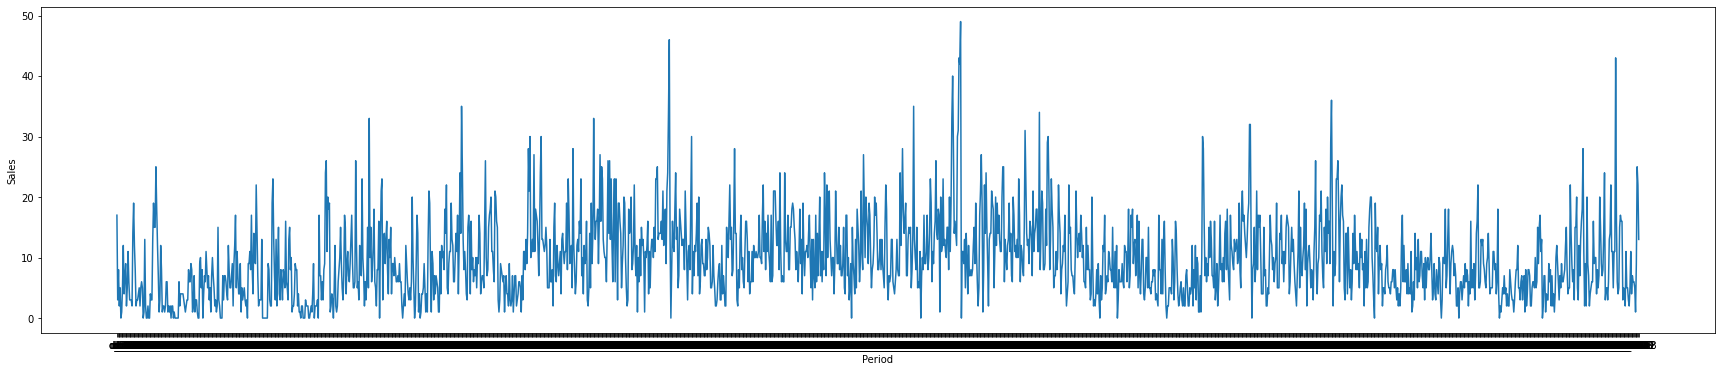

In [ ]:
y_truth = sales.loc[index, 'd_1':'d_1913']

plt.figure(figsize = (30,6))
plt.plot(y_truth)
plt.xlabel('Period')
plt.ylabel('Sales')
plt.show()

# Moving Average (28 days) as Benchmark Model


In [ ]:
scaler = MinMaxScaler(feature_range= (0,1))
y_truth_scaled = scaler.fit_transform(y_truth.values.reshape(-1,1))
train, test = train_test_split(y_truth_scaled, test_size = 0.2)

X_train, y_train = moving_window(train, n_steps_in= 28, n_steps_out= 28)
X_test, y_test = moving_window(test, n_steps_in= 28, n_steps_out= 28)

In [ ]:
mavg_pred = [i.mean() for i in X_test.reshape(X_test.shape[0],X_test.shape[1])]
mavg_pred = scaler.inverse_transform(pd.Series(mavg_pred).values.reshape(-1,1))
mavg_pred = pd.Series([i[0] for i in mavg_pred])

In [ ]:
y_truth_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))
y_truth_test = pd.Series([i[0] for i in y_truth_test])

In [ ]:
rmse_benchmark = sqrt(mean_squared_error(y_truth_test, mavg_pred))
print('RMSE(benchmark): {}'.format(rmse_benchmark))
print('')
print('MAE: {}'.format(mean_absolute_error(y_truth_test, mavg_pred)))
print('Mean: {}'.format(y_truth_test.mean()))
print('MAE to Mean Ratio: {}'.format(mean_absolute_error(y_truth_test, mavg_pred) / y_truth_test.mean() ))

RMSE(benchmark): 5.040526094576292

MAE: 3.740418118466899
Mean: 7.8323170731707314
MAE to Mean Ratio: 0.4775621420230218


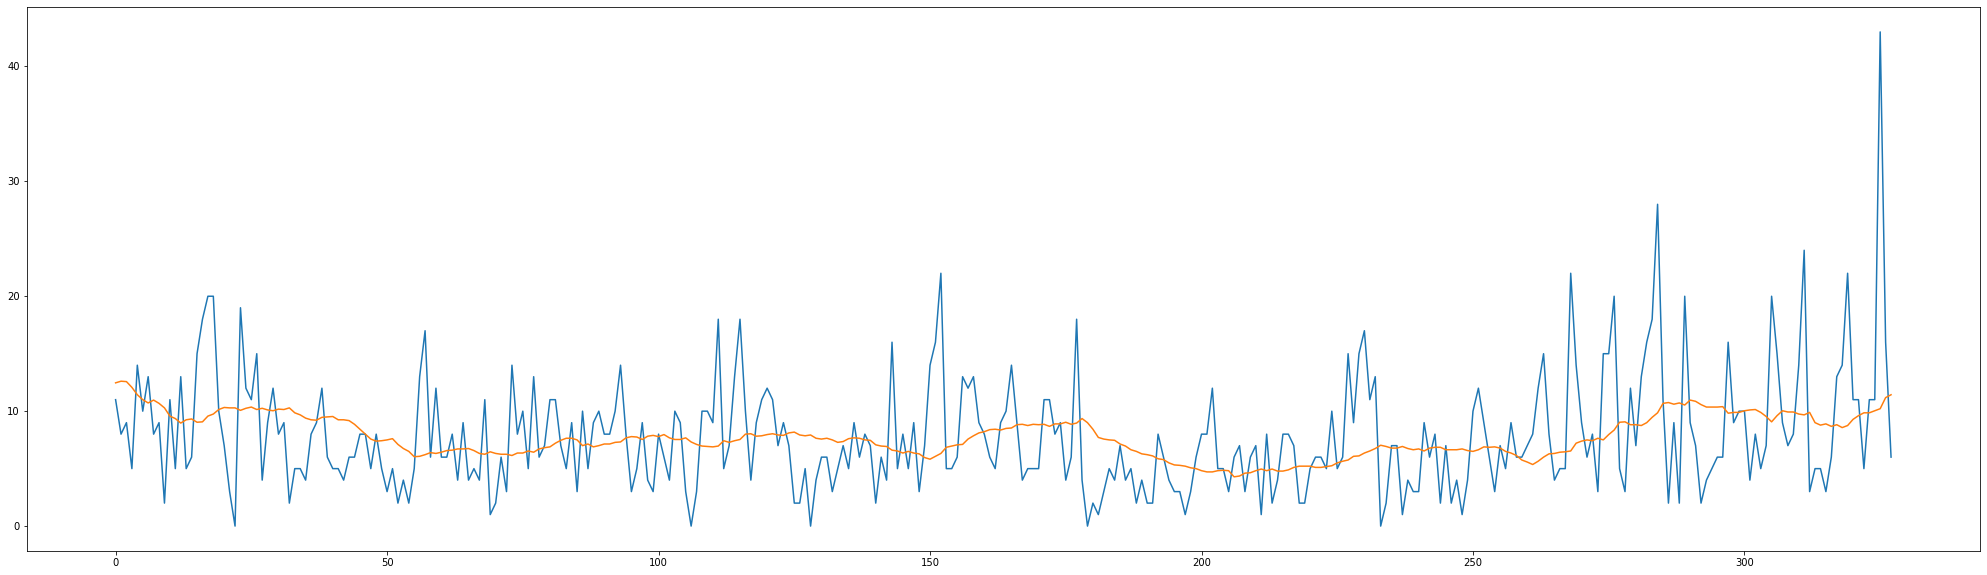

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(y_truth_test)
plt.plot(mavg_pred)
plt.show()

# Univariate Vanilla LSTM

In [ ]:
scaler = MinMaxScaler(feature_range= (0,1))
y_truth_scaled = scaler.fit_transform(y_truth.values.reshape(-1,1))
train, test = train_test_split(y_truth_scaled, test_size = 0.2)

X_train, y_train = moving_window(train, n_steps_in= 28, n_steps_out= 28)
X_test, y_test = moving_window(test, n_steps_in= 28, n_steps_out= 28)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1475, 28, 1)
(1475, 28, 1)
(328, 28, 1)
(328, 28, 1)


In [ ]:
model = Sequential()
model.add(LSTM(256, activation= 'relu', input_shape = (X_train.shape[1],X_train.shape[2])),) # tried 56, 128 hidden nodes
model.add(Dropout(rate = 0.15))
model.add(Dense(28))

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 28)                7196      
Total params: 271,388
Trainable params: 271,388
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_name = 'lstm_uni'
history_file = 'history_' + model_name + '.csv'
model_file = 'model_' + model_name + '.h5'

# csv_logger = CSVLogger(history_file)
# model.fit(X_train, y_train, epochs = 150, batch_size = 16, shuffle= False, validation_data=(X_test, y_test), verbose= 1, callbacks= [csv_logger])
# model.save(model_file)

# files.download(history_file)
# files.download(model_file)

In [ ]:
# Load models

model_path = 'models/' + model_file
history_path = 'models/' + history_file

model = load_model(model_path)
history = pd.read_csv(history_path)

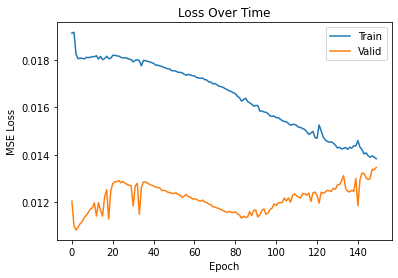

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
lstm_pred = scaler.inverse_transform(model.predict(X_test))
lstm_pred = pd.Series([i[0] for i in lstm_pred])

In [ ]:
y_truth_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))
y_truth_test = pd.Series([i[0] for i in y_truth_test])

In [ ]:
rmse_lstm = sqrt(mean_squared_error(y_truth_test, lstm_pred))
model_score(lstm_pred, y_truth_test, rmse_benchmark)

RMSE: 4.926490249149984
RMSE(benchmark): 5.040526094576292
Relative RMSE (): 0.977376201752231
2.3% improvement in RMSE as compared to Moving Average Model (Benchmark)

MAE: 3.757300884985342
Mean: 7.8323170731707314
MAE to Mean Ratio: 0.4797176684605653


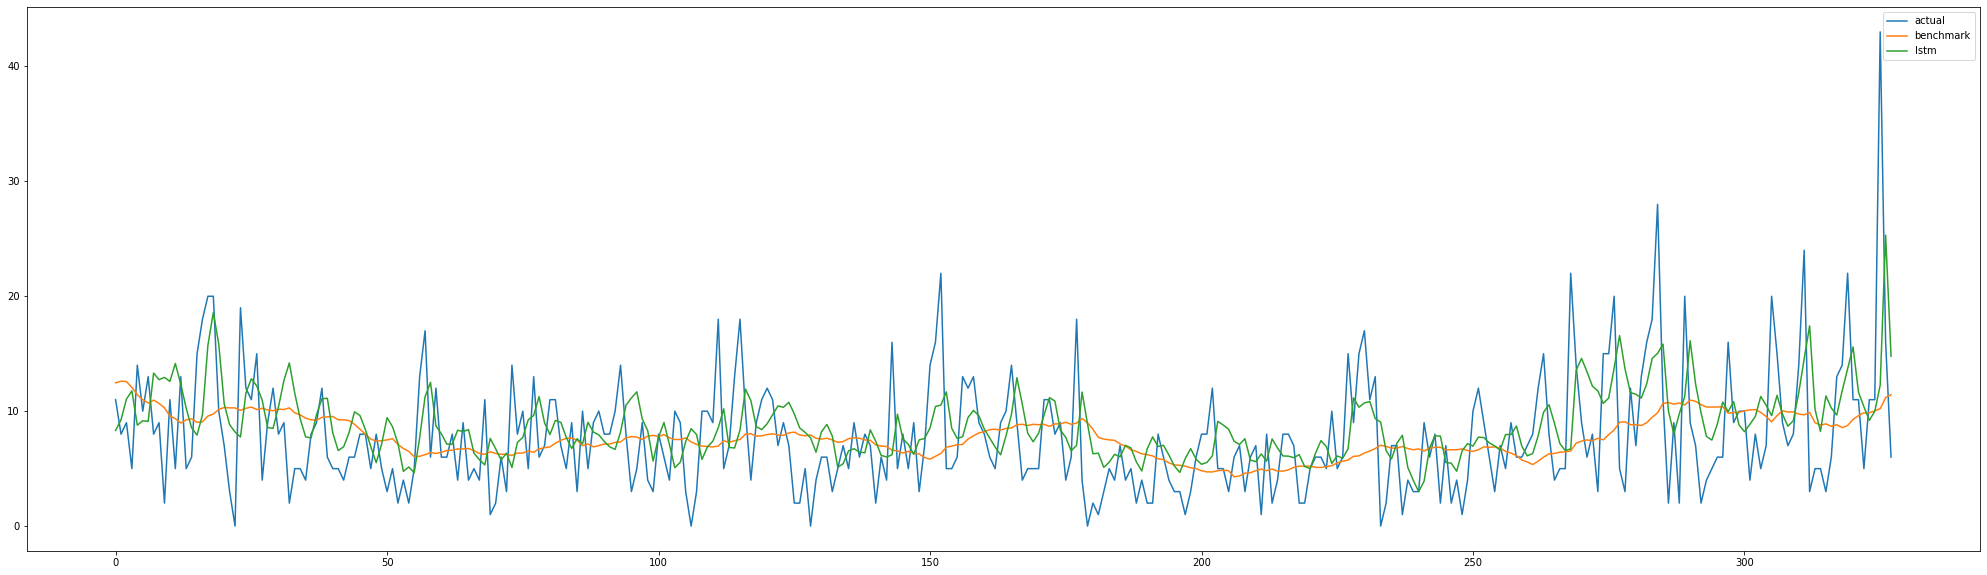

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(y_truth_test, label="actual")
plt.plot(mavg_pred, label="benchmark")
plt.plot(lstm_pred, label= "lstm")
plt.legend()
plt.show()

# Univariate Stacked LSTM

In [ ]:
scaler = MinMaxScaler(feature_range= (0,1))
y_truth_scaled = scaler.fit_transform(y_truth.values.reshape(-1,1))
train, test = train_test_split(y_truth_scaled, test_size = 0.2)

X_train, y_train = moving_window(train, n_steps_in= 28, n_steps_out= 28)
X_test, y_test = moving_window(test, n_steps_in= 28, n_steps_out= 28)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1475, 28, 1)
(1475, 28, 1)
(328, 28, 1)
(328, 28, 1)


In [ ]:
model = Sequential()
model.add(LSTM(50, activation= 'relu', input_shape = (X_train.shape[1],X_train.shape[2]), return_sequences=True))
model.add(LSTM(50, activation= 'relu', return_sequences=True))
model.add(LSTM(50, activation= 'relu', return_sequences=False))
model.add(Dropout(rate = 0.15))
model.add(Dense(28))

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='mean_absolute_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 28, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 28, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 28)                1428      
Total params: 52,228
Trainable params: 52,228
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_name = 'stacked_lstm'
history_file = 'history_' + model_name + '.csv'
model_file = 'model_' + model_name + '.h5'

# csv_logger = CSVLogger(history_file)
# model.fit(X_train, y_train, epochs = 200, batch_size = 16, shuffle= False, validation_data=(X_test, y_test), verbose= 1, callbacks= [csv_logger])
# model.save(model_file)

# files.download(history_file)
# files.download(model_file)

In [ ]:
# Load models

model_path = 'models/' + model_file
history_path = 'models/' + history_file

model = load_model(model_path)
history = pd.read_csv(history_path)

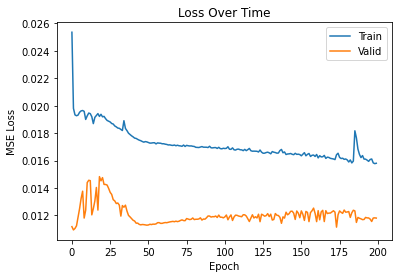

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
slstm_pred = scaler.inverse_transform(model.predict(X_test))
slstm_pred = pd.Series([i[0] for i in slstm_pred])

In [ ]:
y_truth_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))
y_truth_test = pd.Series([i[0] for i in y_truth_test])

In [ ]:
rmse_slstm = sqrt(mean_squared_error(y_truth_test, slstm_pred))
model_score(slstm_pred, y_truth_test, rmse_benchmark)

RMSE: 5.103244880501143
RMSE(benchmark): 5.040526094576292
Relative RMSE (): 1.0124429047182868
-1.2% improvement in RMSE as compared to Moving Average Model (Benchmark)

MAE: 3.889869364296518
Mean: 7.8323170731707314
MAE to Mean Ratio: 0.4966434999958186


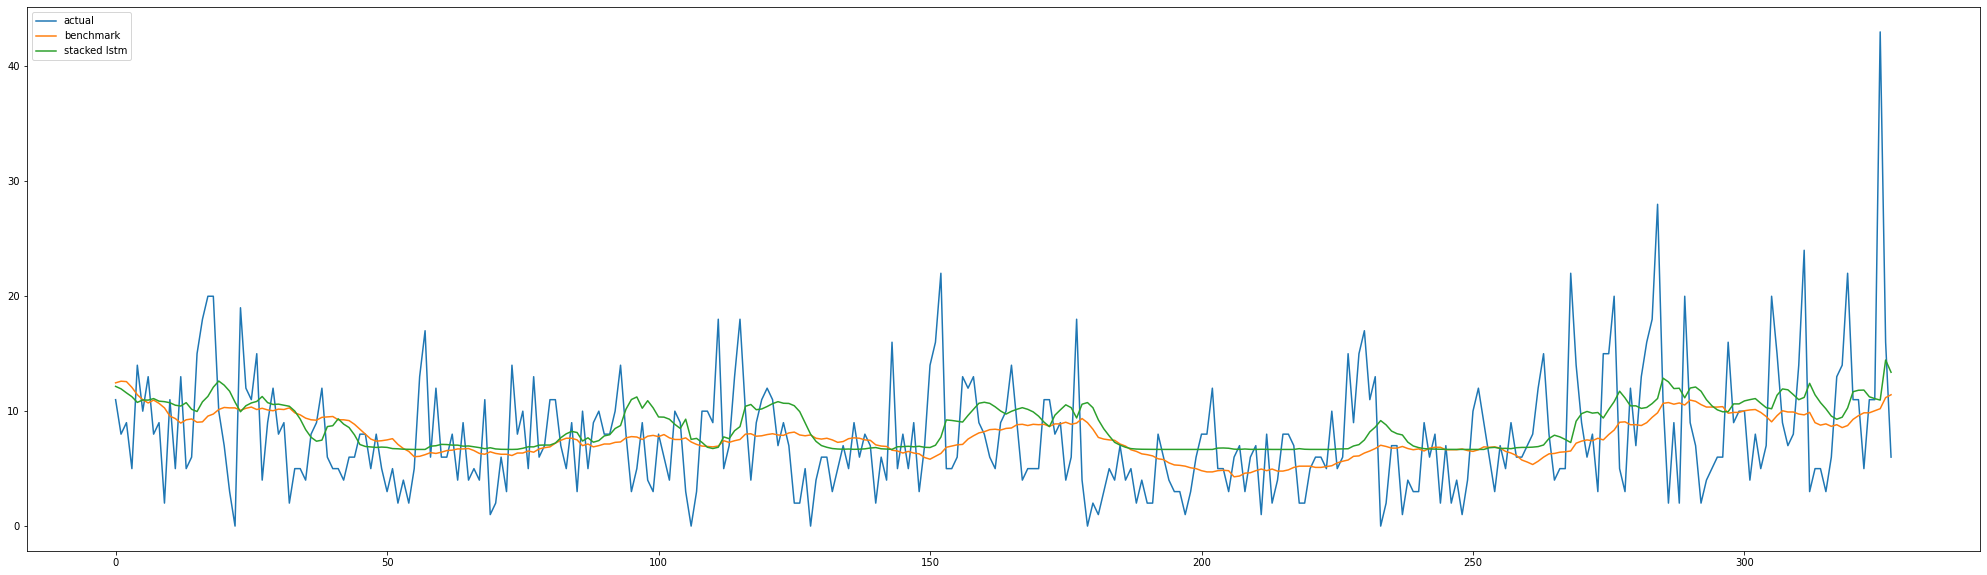

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(y_truth_test, label="actual")
plt.plot(mavg_pred, label="benchmark")
# plt.plot(lstm_pred, label= "lstm")
plt.plot(slstm_pred, label= "stacked lstm")
plt.legend()
plt.show()

# Univariate Encoder Decoder with BiDirectional-LSTM

In [ ]:
scaler = MinMaxScaler(feature_range= (0,1))
y_truth_scaled = scaler.fit_transform(y_truth.values.reshape(-1,1))
train, test = train_test_split(y_truth_scaled, test_size = 0.2)

X_train, y_train = moving_window(train, n_steps_in= 28, n_steps_out= 28)
X_test, y_test = moving_window(test, n_steps_in= 28, n_steps_out= 28)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1475, 28, 1)
(1475, 28, 1)
(328, 28, 1)
(328, 28, 1)


In [ ]:
model = Sequential()
# Encoder
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(RepeatVector(X_train.shape[1]))
# Decoder
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True)))
model.add(Dropout(rate = 0.15))
model.add(TimeDistributed(Dense(1)))

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='mean_absolute_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               20800     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 28, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 28, 100)           60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 100)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 28, 1)             101       
Total params: 81,301
Trainable params: 81,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_name = 'enc_lstm_uni'
history_file = 'history_' + model_name + '.csv'
model_file = 'model_' + model_name + '.h5'

# csv_logger = CSVLogger(history_file)
# model.fit(X_train, y_train, epochs = 300, batch_size = 16, shuffle= False, validation_data=(X_test, y_test), verbose= 1, callbacks= [csv_logger])
# model.save(model_file)

# files.download(history_file)
# files.download(model_file)

In [ ]:
# Load models

model_path = 'models/' + model_file
history_path = 'models/' + history_file

model = load_model(model_path)
history = pd.read_csv(history_path)

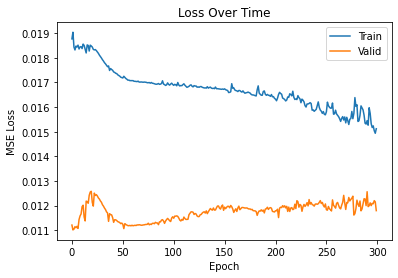

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
enc_pred = scaler.inverse_transform(model.predict(X_test).reshape(X_test.shape[0], X_test.shape[1]))
enc_pred = pd.Series([i[0] for i in enc_pred])

In [ ]:
y_truth_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))
y_truth_test = pd.Series([i[0] for i in y_truth_test])

In [ ]:
rmse_enc = sqrt(mean_squared_error(y_truth_test, enc_pred))
model_score(enc_pred, y_truth_test, rmse_benchmark)

RMSE: 5.020494525122382
RMSE(benchmark): 5.040526094576292
Relative RMSE (): 0.9960258970833492
0.4% improvement in RMSE as compared to Moving Average Model (Benchmark)

MAE: 3.861141659864565
Mean: 7.8323170731707314
MAE to Mean Ratio: 0.4929756576238137


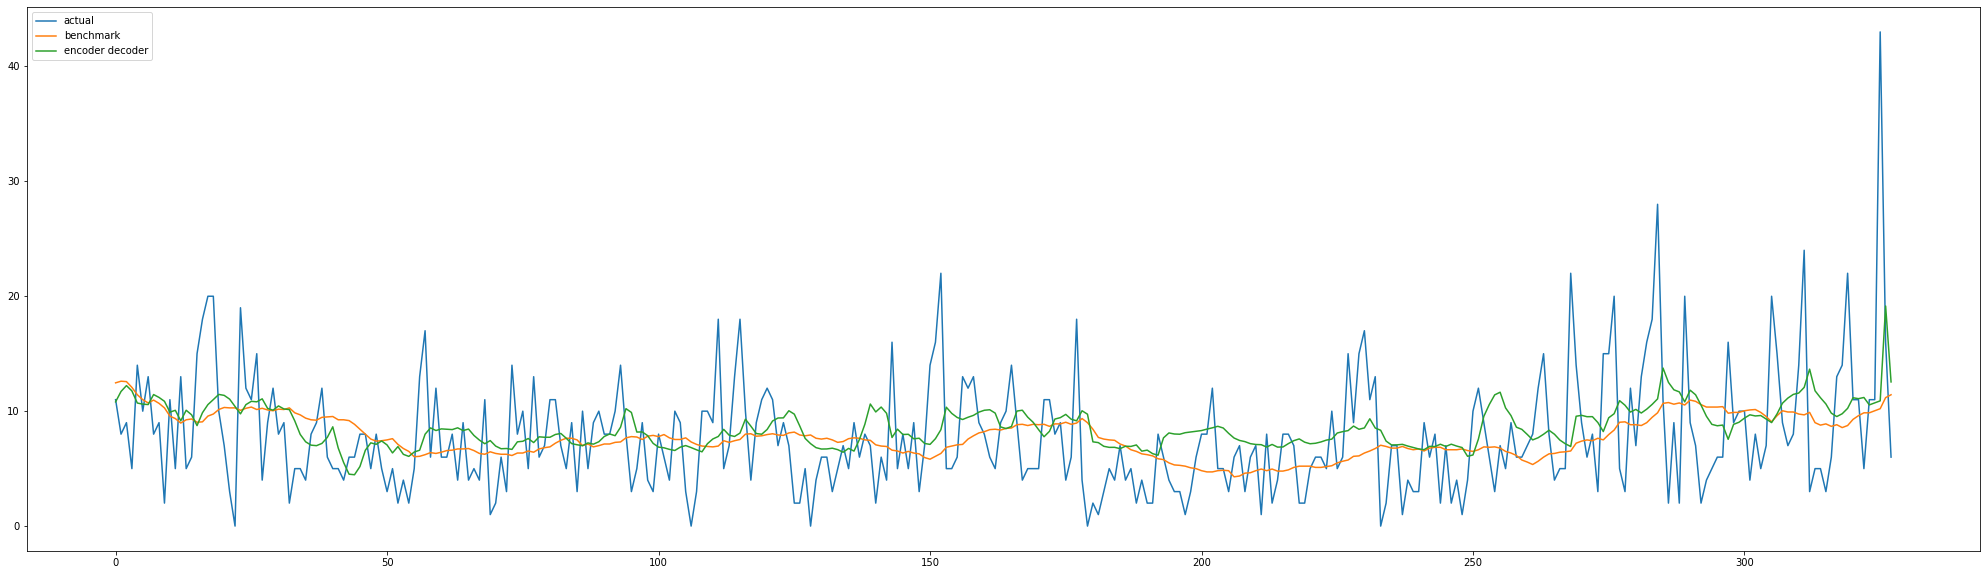

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(y_truth_test, label="actual")
plt.plot(mavg_pred, label="benchmark")
# plt.plot(lstm_pred, label= "lstm")
# plt.plot(slstm_pred, label= "stacked lstm")
plt.plot(enc_pred, label= "encoder decoder")
plt.legend()
plt.show()

# Univariate MLP

In [ ]:
scaler = MinMaxScaler(feature_range= (0,1))
y_truth_scaled = scaler.fit_transform(y_truth.values.reshape(-1,1))
train, test = train_test_split(y_truth_scaled, test_size = 0.2)

X_train, y_train = moving_window(train, n_steps_in= 28, n_steps_out= 28)
X_test, y_test = moving_window(test, n_steps_in= 28, n_steps_out= 28)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1475, 28, 1)
(1475, 28, 1)
(328, 28, 1)
(328, 28, 1)


In [ ]:
n_input = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], n_input) # flatten the input to fit dense layer, thus losing the temporal information (timesteps)
y_train = y_train[:,:,0]

X_test = X_test.reshape(X_test.shape[0], n_input) # flatten the input to fit dense layer

model = Sequential()  # tried 200 -> 100 -> 50 dense layers
model.add(Dense(100, activation= 'relu', input_dim = n_input))
model.add(Dense(50, activation= 'relu'))
model.add(Dropout(rate = 0.15))
model.add(Dense(28))

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='mean_absolute_error')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               2900      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 28)                1428      
Total params: 9,378
Trainable params: 9,378
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_name = 'mlp_uni'
history_file = 'history_' + model_name + '.csv'
model_file = 'model_' + model_name + '.h5'

# csv_logger = CSVLogger(history_file)
# model.fit(X_train, y_train, epochs = 100, batch_size = 32, shuffle= False, validation_data=(X_test, y_test), verbose= 1, callbacks= [csv_logger])
# model.save(model_file)

# files.download(history_file)
# files.download(model_file)

In [ ]:
# Load models

model_path = 'models/' + model_file
history_path = 'models/' + history_file

model = load_model(model_path)
history = pd.read_csv(history_path)

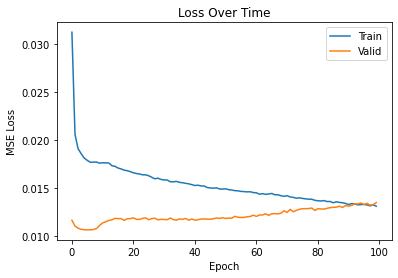

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
mlp_pred = scaler.inverse_transform(model.predict(X_test))
mlp_pred = pd.Series([i[0] for i in mlp_pred])

In [ ]:
y_truth_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))
y_truth_test = pd.Series([i[0] for i in y_truth_test])

In [ ]:
rmse_mlp = sqrt(mean_squared_error(y_truth_test, mlp_pred))
model_score(mlp_pred, y_truth_test, rmse_benchmark)

RMSE: 5.112352782999576
RMSE(benchmark): 5.040526094576292
Relative RMSE (): 1.0142498396150692
-1.4% improvement in RMSE as compared to Moving Average Model (Benchmark)

MAE: 3.8375079688139078
Mean: 7.8323170731707314
MAE to Mean Ratio: 0.48995819921018363


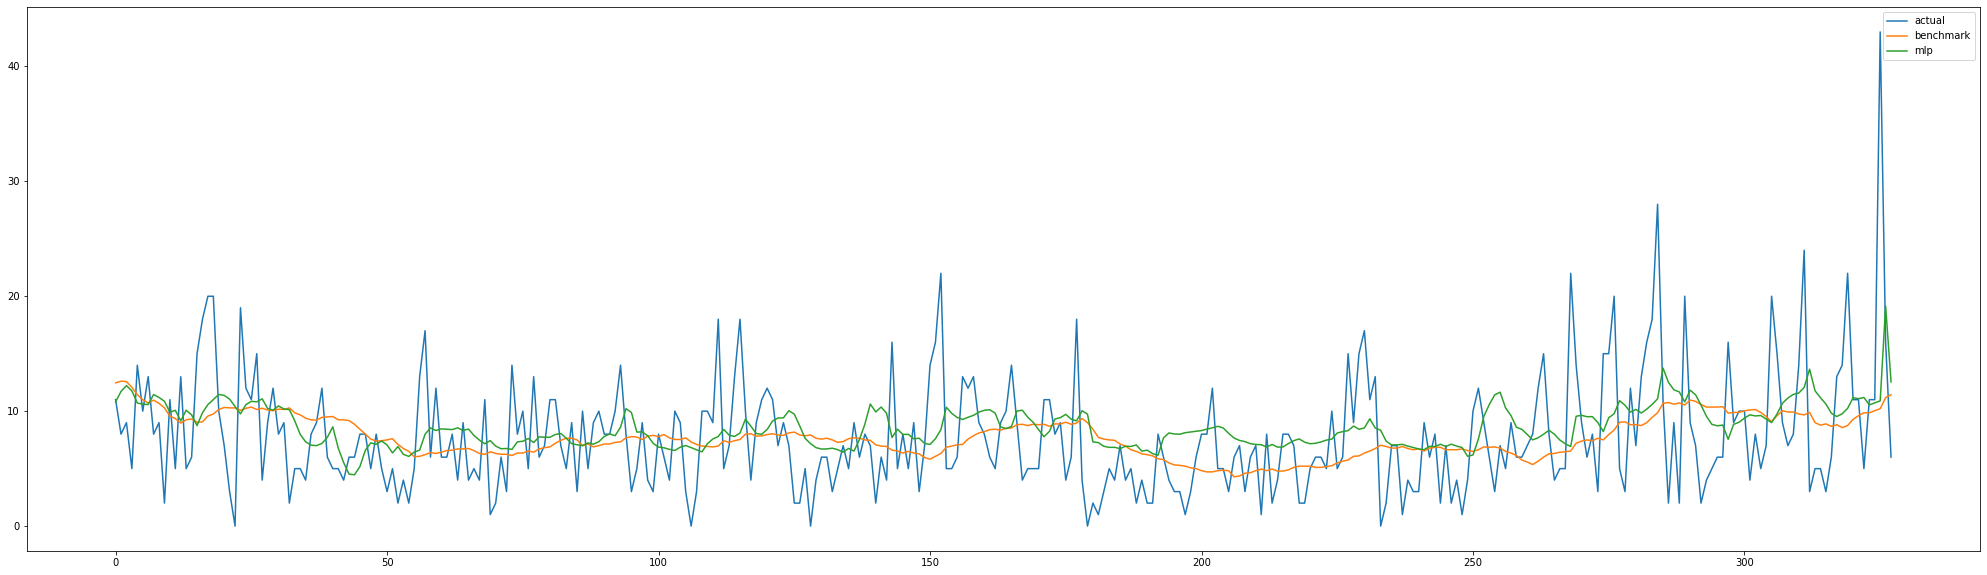

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(y_truth_test, label="actual")
plt.plot(mavg_pred, label="benchmark")
# plt.plot(lstm_pred, label= "lstm")
# plt.plot(slstm_pred, label= "stacked lstm")
# plt.plot(enc_pred, label= "encoder decoder")
plt.plot(enc_pred, label= "mlp")
plt.legend()
plt.show()

# Univariate Vanilla Bi-Directional LSTM

In [ ]:
scaler = MinMaxScaler(feature_range= (0,1))
y_truth_scaled = scaler.fit_transform(y_truth.values.reshape(-1,1))
train, test = train_test_split(y_truth_scaled, test_size = 0.2)

X_train, y_train = moving_window(train, n_steps_in= 28, n_steps_out= 28)
X_test, y_test = moving_window(test, n_steps_in= 28, n_steps_out= 28)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1475, 28, 1)
(1475, 28, 1)
(328, 28, 1)
(328, 28, 1)


In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(256, activation= 'relu'), input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(Dropout(rate = 0.15))
model.add(Dense(28))

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='mean_absolute_error')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 512)               528384    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 28)                14364     
Total params: 542,748
Trainable params: 542,748
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_name = 'bilstm_uni'
history_file = 'history_' + model_name + '.csv'
model_file = 'model_' + model_name + '.h5'

# csv_logger = CSVLogger(history_file)
# model.fit(X_train, y_train, epochs = 150, batch_size = 16, shuffle= False, validation_data=(X_test, y_test), verbose= 1, callbacks= [csv_logger])
# model.save(model_file)

# files.download(history_file)
# files.download(model_file)

In [ ]:
# Load models

model_path = 'models/' + model_file
history_path = 'models/' + history_file

model = load_model(model_path)
history = pd.read_csv(history_path)

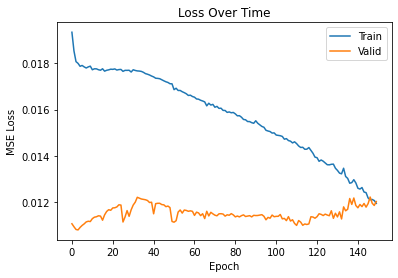

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
blstm_pred = scaler.inverse_transform(model.predict(X_test))
blstm_pred = pd.Series([i[0] for i in blstm_pred])

In [ ]:
y_truth_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))
y_truth_test = pd.Series([i[0] for i in y_truth_test])

In [ ]:
rmse_blstm = sqrt(mean_squared_error(y_truth_test, blstm_pred))
model_score(blstm_pred, y_truth_test, rmse_benchmark)

RMSE: 5.084832678898028
RMSE(benchmark): 5.040526094576292
Relative RMSE (): 1.0087900714112779
-0.9% improvement in RMSE as compared to Moving Average Model (Benchmark)

MAE: 3.7841188678199926
Mean: 7.8323170731707314
MAE to Mean Ratio: 0.4831416849532727


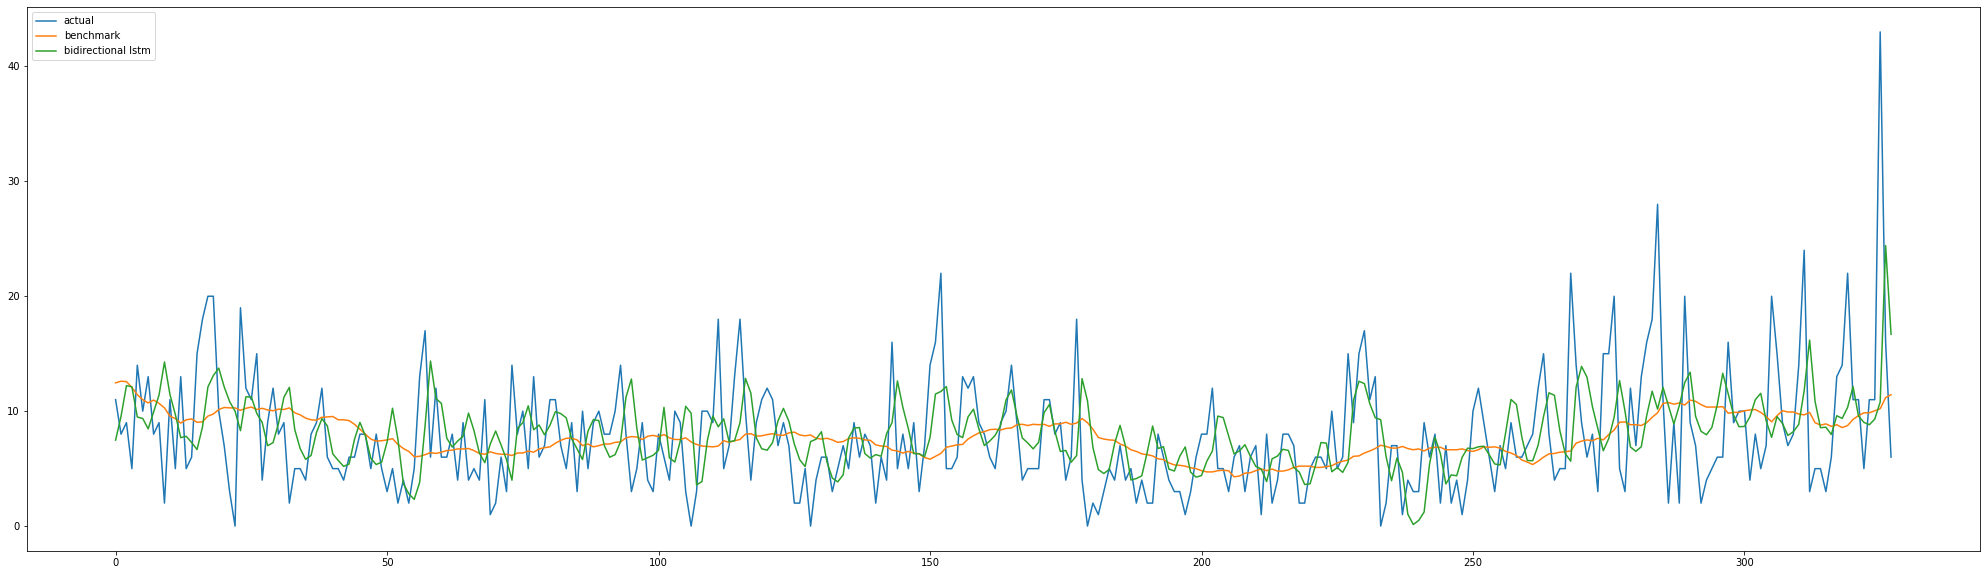

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(y_truth_test, label="actual")
plt.plot(mavg_pred, label="benchmark")
# plt.plot(lstm_pred, label= "lstm")
# plt.plot(slstm_pred, label= "stacked lstm")
# plt.plot(enc_pred, label= "encoder decoder")
plt.plot(blstm_pred, label= "bidirectional lstm")
plt.legend()
plt.show()

# Univariate ConvLSTM

In [ ]:
scaler = MinMaxScaler(feature_range= (0,1))
y_truth_scaled = scaler.fit_transform(y_truth.values.reshape(-1,1))
train, test = train_test_split(y_truth_scaled, test_size = 0.2)

X_train, y_train = moving_window(train, n_steps_in= 28, n_steps_out= 28)
X_test, y_test = moving_window(test, n_steps_in= 28, n_steps_out= 28)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1475, 28, 1)
(1475, 28, 1)
(328, 28, 1)
(328, 28, 1)


In [ ]:
# reshape train data into 4 sub-sequences of time steps [samples, subsequences, timesteps, features]

X_train = X_train.reshape(X_train.shape[0], 4, int(X_train.shape[1]/4), X_train.shape[2])
print(X_train.shape)

X_test = X_test.reshape(X_test.shape[0], 4, int(X_test.shape[1]/4), X_test.shape[2])
print(X_test.shape)

(1475, 4, 7, 1)
(328, 4, 7, 1)


In [ ]:
model = Sequential()
model.add(Input(shape = (None, X_train.shape[2], X_train.shape[3])))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))) # tried kernel_size = 3
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(rate = 0.15))
model.add(Dense(28))

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='mean_absolute_error')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 7, 64)       128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 3, 64)       0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 192)         0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                48600     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 28)                1428      
Total params: 50,156
Trainable params: 50,156
Non-trainable params: 0
__________________________________________________

In [ ]:
model_name = 'conv_lstm_uni'
history_file = 'history_' + model_name + '.csv'
model_file = 'model_' + model_name + '.h5'

# csv_logger = CSVLogger(history_file)
# model.fit(X_train, y_train, epochs = 300, batch_size = 16, shuffle= False, validation_data=(X_test, y_test), verbose= 1, callbacks= [csv_logger])
# model.save(model_file)

# files.download(history_file)
# files.download(model_file)

In [ ]:
# Load models

model_path = 'models/' + model_file
history_path = 'models/' + history_file

model = load_model(model_path)
history = pd.read_csv(history_path)

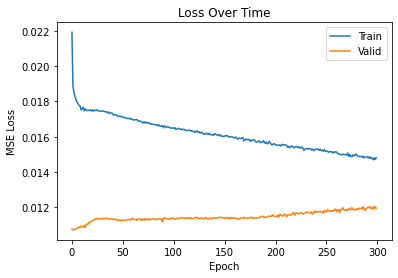

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
convlstm_pred = scaler.inverse_transform(model.predict(X_test))
convlstm_pred = pd.Series([i[0] for i in convlstm_pred])

In [ ]:
y_truth_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))
y_truth_test = pd.Series([i[0] for i in y_truth_test])

In [ ]:
rmse_convlstm = sqrt(mean_squared_error(y_truth_test, convlstm_pred))
model_score(convlstm_pred, y_truth_test, rmse_benchmark)

RMSE: 5.112866407000356
RMSE(benchmark): 5.040526094576292
Relative RMSE (): 1.014351738502436
-1.4% improvement in RMSE as compared to Moving Average Model (Benchmark)

MAE: 3.897882705054632
Mean: 7.8323170731707314
MAE to Mean Ratio: 0.4976666124009028


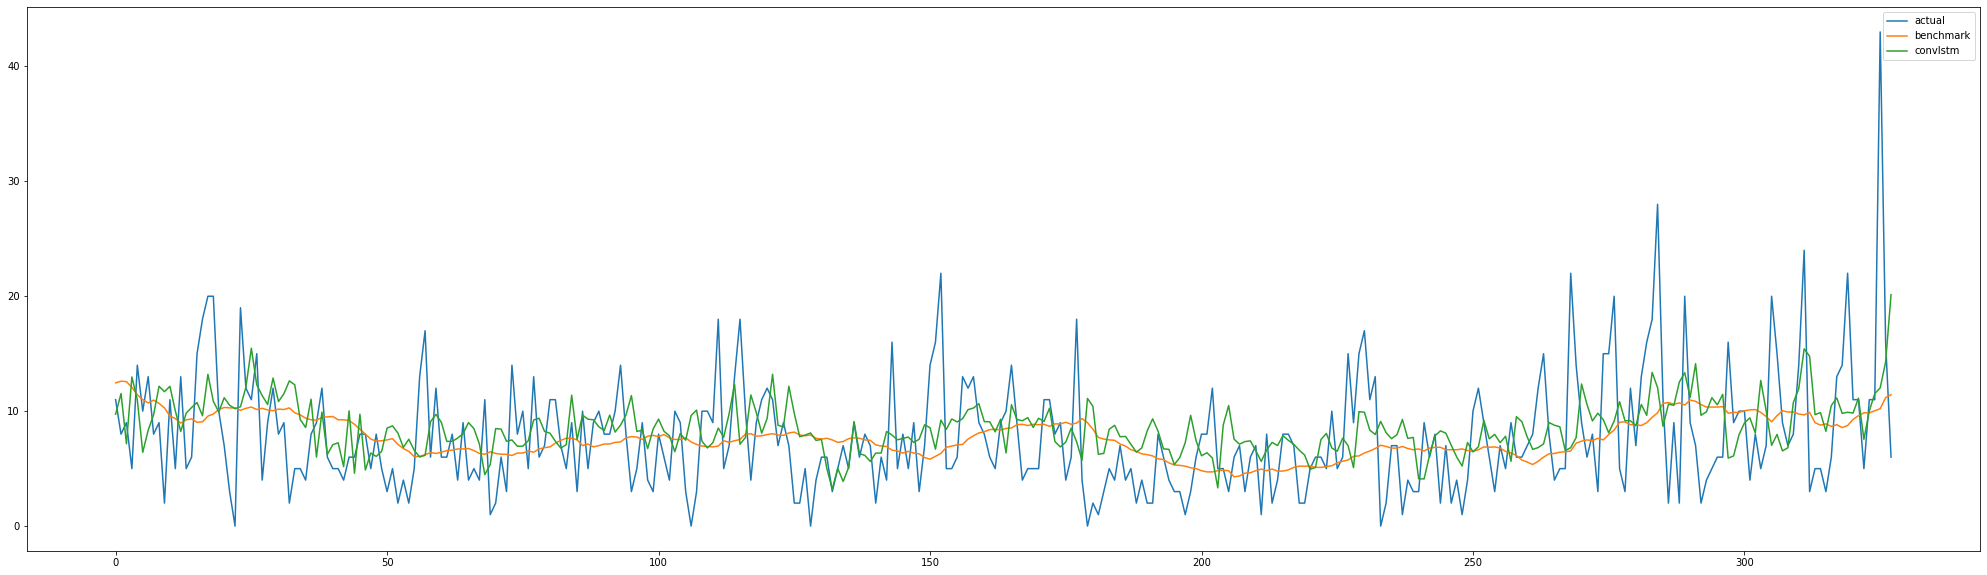

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(y_truth_test, label="actual")
plt.plot(mavg_pred, label="benchmark")
# plt.plot(lstm_pred, label= "lstm")
plt.plot(convlstm_pred, label= "convlstm")
plt.legend()
plt.show()

# Univariate Wavenet

In [ ]:
scaler = MinMaxScaler(feature_range= (0,1))
y_truth_scaled = scaler.fit_transform(y_truth.values.reshape(-1,1))
train, test = train_test_split(y_truth_scaled, test_size = 0.2)

X_train, y_train = moving_window(train, n_steps_in= 28, n_steps_out= 28)
X_test, y_test = moving_window(test, n_steps_in= 28, n_steps_out= 28)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1475, 28, 1)
(1475, 28, 1)
(328, 28, 1)
(328, 28, 1)


In [ ]:
# Ref:https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Full.ipynb
# Ref2:https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv2/

# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
  # preprocessing - equivalent to time-distributed dense
  x = Conv1D(16, 1, padding='same', activation='relu')(x) 
  
  # filter convolution
  x_f = Conv1D(filters=n_filters,
                kernel_size=filter_width, 
                padding='causal',
                dilation_rate=dilation_rate)(x)
  
  # gating convolution
  x_g = Conv1D(filters=n_filters,
                kernel_size=filter_width, 
                padding='causal',
                dilation_rate=dilation_rate)(x)
  
  # multiply filter and gating branches
  z = Multiply()([Activation('tanh')(x_f),
                  Activation('sigmoid')(x_g)])
  
  # postprocessing - equivalent to time-distributed dense
  z = Conv1D(16, 1, padding='same', activation='relu')(z)
  
  # residual connection
  x = Add()([x, z])    
  
  # collect skip connections
  skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

model = Model(history_seq, out)
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='mean_absolute_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 28, 16)       32          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 28, 32)       1056        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 28, 32)       1056        conv1d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
# model = Sequential()
# model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=1))
# model.add(Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=2))
# model.add(Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=4))
# model.add(Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=8))
# model.add(Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=1))
# model.add(Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=2))
# model.add(Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=4))
# model.add(Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=8)) 
# model.add(Conv1D(filters=10, kernel_size=1))
# model.add(Dense(28))

# model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='mean_absolute_error')
# model.summary()

In [ ]:
model_name = 'wavenet_uni'
history_file = 'history_' + model_name + '.csv'
model_file = 'model_' + model_name + '.h5'

# csv_logger = CSVLogger(history_file)
# model.fit(X_train, y_train, epochs = 125, batch_size = 16, shuffle= False, validation_data=(X_test, y_test), verbose= 1, callbacks= [csv_logger])
# model.save(model_file)

# files.download(history_file)
# files.download(model_file)

In [ ]:
# Load models

model_path = 'models/' + model_file
history_path = 'models/' + history_file

model = load_model(model_path)
history = pd.read_csv(history_path)

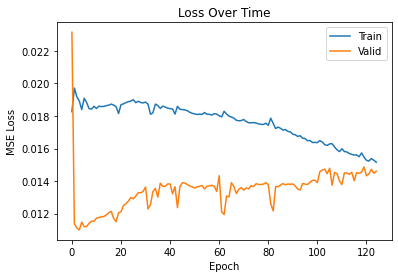

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
wavenet_pred = model.predict(X_test)[:,:,0]
wavenet_pred = scaler.inverse_transform(wavenet_pred)
wavenet_pred = pd.Series([i[0] for i in wavenet_pred])

In [ ]:
y_truth_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))
y_truth_test = pd.Series([i[0] for i in y_truth_test])

In [ ]:
rmse_wavenet = sqrt(mean_squared_error(y_truth_test, wavenet_pred))
model_score(wavenet_pred, y_truth_test, rmse_benchmark)

RMSE: 5.367339335941123
RMSE(benchmark): 5.040526094576292
Relative RMSE (): 1.0648371291473897
-6.5% improvement in RMSE as compared to Moving Average Model (Benchmark)

MAE: 4.246364808664089
Mean: 7.8323170731707314
MAE to Mean Ratio: 0.5421594617523633


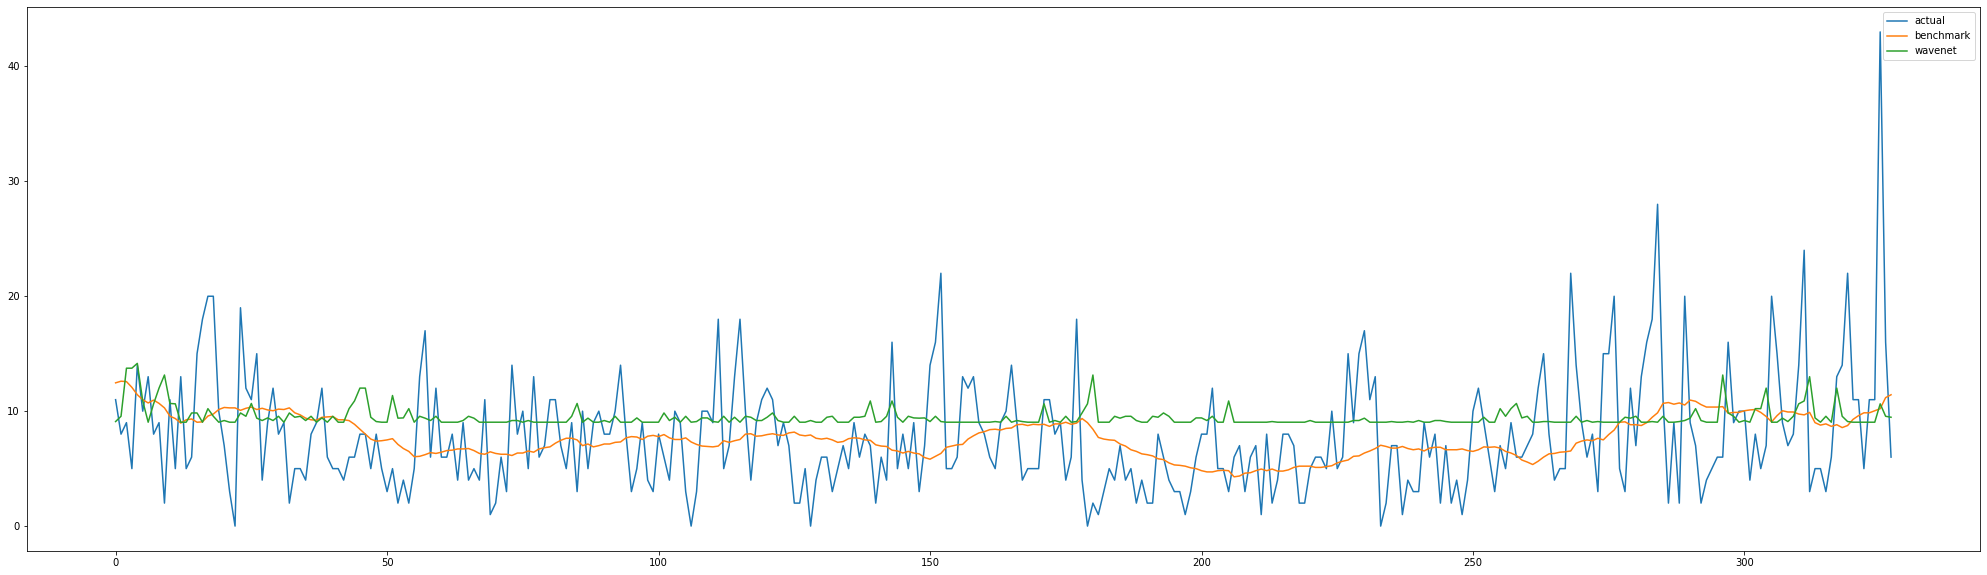

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(y_truth_test, label="actual")
plt.plot(mavg_pred, label="benchmark")
# plt.plot(lstm_pred, label= "lstm")
plt.plot(wavenet_pred, label= "wavenet")
plt.legend()
plt.show()

# Part 2: Multivariate Multisteps Forecast

# Features Engineering

I will be adding the following features on top of the daily sales for model prediction:

1) rolling mean of 7, 14 and 28 days

2) lag of 1, 2 and 3 days

3) lag difference of 1 day


In [ ]:
print(index)
sales.loc[index,:]

1628


id            FOODS_1_018_CA_1_validation
item_id                       FOODS_1_018
dept_id                           FOODS_1
cat_id                              FOODS
store_id                             CA_1
                         ...             
d_1910                                  9
d_1911                                 25
d_1912                                 22
d_1913                                 13
ZERO_COUNT                             53
Name: 1628, Length: 1920, dtype: object

In [ ]:
# get sales data
y_truth_df = sales.loc[index, 'd_1':'d_1913']
y_truth_df = pd.DataFrame(y_truth_df)
y_truth_df.columns = ['Sales']

# create rolling mean of 7 days feature
y_truth_df['roll_7'] = y_truth_df['Sales'].rolling(7).mean()
# impute the first 6 missing values with first non-nan value
y_truth_df['roll_7'].fillna(y_truth_df['roll_7'][y_truth_df['roll_7'].notna()][0], inplace = True)

# create rolling mean of 14 days feature
y_truth_df['roll_14'] = y_truth_df['Sales'].rolling(14).mean()
# impute the first 13 missing values with first non-nan value
y_truth_df['roll_14'].fillna(y_truth_df['roll_14'][y_truth_df['roll_14'].notna()][0], inplace = True)

# create rolling mean of 28 days feature
y_truth_df['roll_28'] = y_truth_df['Sales'].rolling(28).mean()
# impute the first 27 missing values with first non-nan value
y_truth_df['roll_28'].fillna(y_truth_df['roll_28'][y_truth_df['roll_28'].notna()][0], inplace = True)

# create lag 1 day feature
y_truth_df['lag_1'] = y_truth_df['Sales'].shift(1)
# impute the first missing values with last non-nan value
y_truth_df['lag_1'].fillna(y_truth_df['lag_1'][y_truth_df['lag_1'].notna()][0], inplace = True)

# create lag 2 day feature
y_truth_df['lag_2'] = y_truth_df['Sales'].shift(2)
# impute the first few missing values with last non-nan value
y_truth_df['lag_2'].fillna(y_truth_df['lag_2'][y_truth_df['lag_2'].notna()][0], inplace = True)

# create lag 3 day feature
y_truth_df['lag_3'] = y_truth_df['Sales'].shift(3)
# impute the first few missing values with last non-nan value
y_truth_df['lag_3'].fillna(y_truth_df['lag_3'][y_truth_df['lag_3'].notna()][0], inplace = True)

# create lag difference of 1 day feature
y_truth_df['lag_diff_1'] = y_truth_df['Sales'].diff(1)
# impute the first few missing values with first non-nan value
y_truth_df['lag_diff_1'].fillna(y_truth_df['lag_diff_1'][y_truth_df['lag_diff_1'].notna()][0], inplace = True)

y_truth_df.head(20)

Sales    roll_7   roll_14   roll_28  lag_1  lag_2  lag_3  lag_diff_1
d_1     17  5.142857  5.714286  6.178571     17     17     17         -14
d_2      3  5.142857  5.714286  6.178571     17     17     17         -14
d_3      8  5.142857  5.714286  6.178571      3     17     17           5
d_4      2  5.142857  5.714286  6.178571      8      3     17          -6
d_5      5  5.142857  5.714286  6.178571      2      8      3           3
d_6      0  5.142857  5.714286  6.178571      5      2      8          -5
d_7      1  5.142857  5.714286  6.178571      0      5      2           1
d_8      5  3.428571  5.714286  6.178571      1      0      5           4
d_9     12  4.714286  5.714286  6.178571      5      1      0           7
d_10     4  4.142857  5.714286  6.178571     12      5      1          -8
d_11     7  4.857143  5.714286  6.178571      4     12      5           3
d_12     9  5.428571  5.714286  6.178571      7      4     12           2
d_13     2  5.714286  5.714286  6.178571      9      7      4          -7
d_14     5  6.285714  5.714286  6.178571      2      9      7           3
d_15    11  7.142857  5.285714  6.178571      5      2      9           6
d_16     6  6.285714  5.500000  6.178571     11      5      2          -5
d_17     3  6.142857  5.142857  6.178571      6     11      5          -3
d_18     3  5.571429  5.214286  6.178571      3      6     11           0
d_19     3  4.714286  5.071429  6.178571      3      3      6           0
d_20     2  4.714286  5.214286  6.178571      3      3      3          -1

# Multivariate Vanilla LSTM

In [ ]:
y_truth_df_scaled = y_truth_df.copy() # copy another dataframe for scaled version

# scale each column with MinMax(0,1) or only lag_diff_1 column with MinMax(-1,1)  
ct = ColumnTransformer(transformers= [('scaler1', MinMaxScaler(feature_range= (0,1)),
                                  ['Sales',	'roll_7',	'roll_14',	'roll_28', 'lag_1',	'lag_2', 'lag_3']),
                                 ('scaler2', MinMaxScaler(feature_range= (-1,1)),
                                  ['lag_diff_1'])])
y_truth_df_scaled = ct.fit_transform(y_truth_df)

# create another scaler for Sales column, to do  inverse_transform for predict sales later
scaler = MinMaxScaler(feature_range= (0,1))
scaler.fit(y_truth_df['Sales'].values.reshape(-1,1))

train, test = train_test_split(y_truth_df_scaled, test_size = 0.2)
X_train, y_train = moving_window(train, n_steps_in= 28, n_steps_out= 28)
X_test, y_test = moving_window(test, n_steps_in= 28, n_steps_out= 28)

y_train = y_train[:,:,0] # only predict sales column (i.e. first feature of dataframe)
y_test = y_test[:,:,0] # only predict sales column (i.e. first feature of dataframe)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1475, 28, 8)
(1475, 28)
(328, 28, 8)
(328, 28)


In [ ]:
model = Sequential()
model.add(LSTM(256, activation= 'relu', input_shape = (X_train.shape[1],X_train.shape[2])),) # tried 56, 128 hidden nodes
model.add(Dropout(rate = 0.15))
model.add(Dense(28))

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='mean_absolute_error')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 256)               271360    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 28)                7196      
Total params: 278,556
Trainable params: 278,556
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_name = 'lstm_multi'
history_file = 'history_' + model_name + '.csv'
model_file = 'model_' + model_name + '.h5'

# csv_logger = CSVLogger(history_file)
# model.fit(X_train, y_train, epochs = 80, batch_size = 16, shuffle= False, validation_data=(X_test, y_test), verbose= 1, callbacks= [csv_logger])
# model.save(model_file)

# files.download(history_file)
# files.download(model_file)

In [ ]:
# Load models

model_path = 'models/' + model_file
history_path = 'models/' + history_file

model = load_model(model_path)
history = pd.read_csv(history_path)

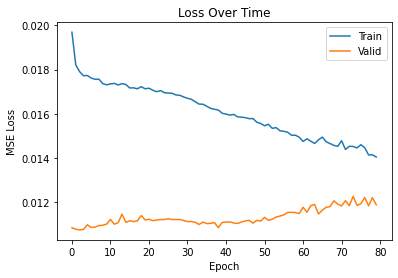

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
lstm_multi_pred = scaler.inverse_transform(model.predict(X_test))
lstm_multi_pred = pd.Series([i[0] for i in lstm_multi_pred])

In [ ]:
y_truth_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))
y_truth_test = pd.Series([i[0] for i in y_truth_test])

In [ ]:
rmse_lstm_multi = sqrt(mean_squared_error(y_truth_test, lstm_multi_pred))
model_score(lstm_multi_pred, y_truth_test, rmse_benchmark)

RMSE: 4.790807088804364
RMSE(benchmark): 5.040526094576292
Relative RMSE (): 0.9504577496304143
5.0% improvement in RMSE as compared to Moving Average Model (Benchmark)

MAE: 3.485847639601405
Mean: 7.8323170731707314
MAE to Mean Ratio: 0.4450595662862051


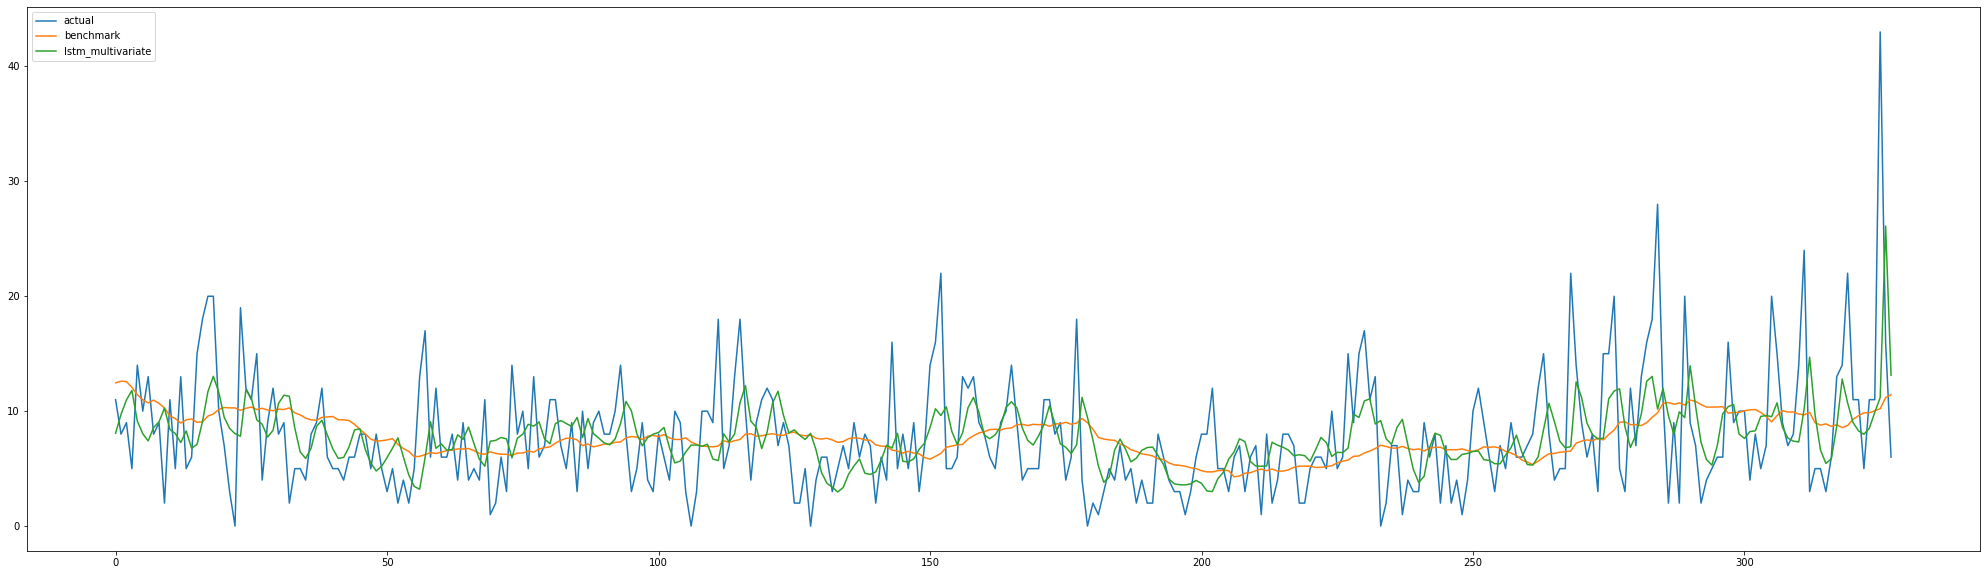

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(y_truth_test, label="actual")
plt.plot(mavg_pred, label="benchmark")
# plt.plot(lstm_pred, label= "lstm_univariate")
plt.plot(lstm_multi_pred, label= "lstm_multivariate")
plt.legend()
plt.show()

# Multivariate Stacked LSTM

In [ ]:
y_truth_df_scaled = y_truth_df.copy() # copy another dataframe for scaled version

# scale each column with MinMax(0,1) or only lag_diff_1 column with MinMax(-1,1)  
ct = ColumnTransformer(transformers= [('scaler1', MinMaxScaler(feature_range= (0,1)),
                                  ['Sales',	'roll_7',	'roll_14',	'roll_28', 'lag_1',	'lag_2', 'lag_3']),
                                 ('scaler2', MinMaxScaler(feature_range= (-1,1)),
                                  ['lag_diff_1'])])
y_truth_df_scaled = ct.fit_transform(y_truth_df)

# create another scaler for Sales column, to do  inverse_transform for predict sales later
scaler = MinMaxScaler(feature_range= (0,1))
scaler.fit(y_truth_df['Sales'].values.reshape(-1,1))

train, test = train_test_split(y_truth_df_scaled, test_size = 0.2)
X_train, y_train = moving_window(train, n_steps_in= 28, n_steps_out= 28)
X_test, y_test = moving_window(test, n_steps_in= 28, n_steps_out= 28)

y_train = y_train[:,:,0] # only predict sales column (i.e. first feature of dataframe)
y_test = y_test[:,:,0] # only predict sales column (i.e. first feature of dataframe)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1475, 28, 8)
(1475, 28)
(328, 28, 8)
(328, 28)


In [ ]:
model = Sequential()
model.add(LSTM(50, activation= 'relu', input_shape = (X_train.shape[1],X_train.shape[2]), return_sequences=True))
model.add(LSTM(50, activation= 'relu', return_sequences=True))
model.add(LSTM(50, activation= 'relu', return_sequences=False))
model.add(Dropout(rate = 0.15))
model.add(Dense(28))

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='mean_absolute_error')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 28, 50)            11800     
_________________________________________________________________
lstm_10 (LSTM)               (None, 28, 50)            20200     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 28)                1428      
Total params: 53,628
Trainable params: 53,628
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_name = 'stacked_lstm_multi'
history_file = 'history_' + model_name + '.csv'
model_file = 'model_' + model_name + '.h5'

# csv_logger = CSVLogger(history_file)
# model.fit(X_train, y_train, epochs = 150, batch_size = 16, shuffle= False, validation_data=(X_test, y_test), verbose= 1, callbacks= [csv_logger])
# model.save(model_file)

# files.download(history_file)
# files.download(model_file)

In [ ]:
# Load models

model_path = 'models/' + model_file
history_path = 'models/' + history_file

model = load_model(model_path)
history = pd.read_csv(history_path)

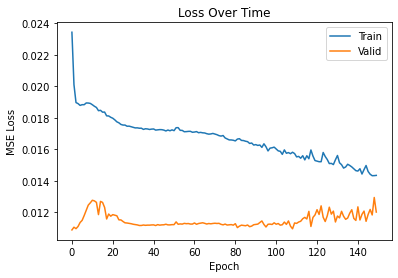

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
slstm_multi_pred = scaler.inverse_transform(model.predict(X_test))
slstm_multi_pred = pd.Series([i[0] for i in slstm_multi_pred])

In [ ]:
y_truth_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))
y_truth_test = pd.Series([i[0] for i in y_truth_test])

In [ ]:
rmse_slstm_multi = sqrt(mean_squared_error(y_truth_test, slstm_multi_pred))
model_score(slstm_multi_pred, y_truth_test, rmse_benchmark)

RMSE: 5.079947352239499
RMSE(benchmark): 5.040526094576292
Relative RMSE (): 1.0078208617361637
-0.8% improvement in RMSE as compared to Moving Average Model (Benchmark)

MAE: 3.8655011464909808
Mean: 7.8323170731707314
MAE to Mean Ratio: 0.4935322600424452


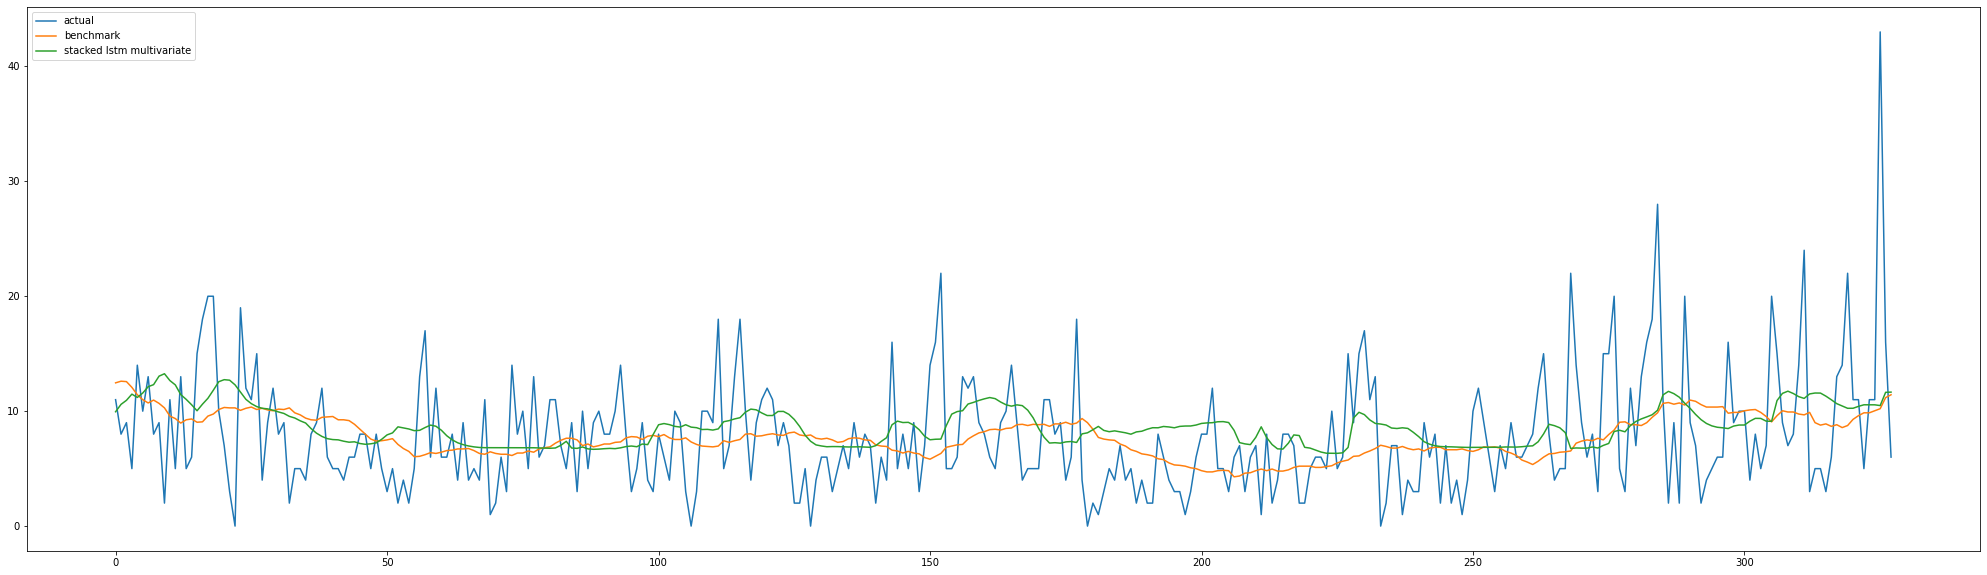

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(y_truth_test, label="actual")
plt.plot(mavg_pred, label="benchmark")
plt.plot(slstm_multi_pred, label= "stacked lstm multivariate")

plt.legend()
plt.show()

# Multivariate Encoder Decoder with LSTM

In [ ]:
y_truth_df_scaled = y_truth_df.copy() # copy another dataframe for scaled version

# scale each column with MinMax(0,1) or only lag_diff_1 column with MinMax(-1,1)  
ct = ColumnTransformer(transformers= [('scaler1', MinMaxScaler(feature_range= (0,1)),
                                  ['Sales',	'roll_7',	'roll_14',	'roll_28', 'lag_1',	'lag_2', 'lag_3']),
                                 ('scaler2', MinMaxScaler(feature_range= (-1,1)),
                                  ['lag_diff_1'])])
y_truth_df_scaled = ct.fit_transform(y_truth_df)

# create another scaler for Sales column, to do  inverse_transform for predict sales later
scaler = MinMaxScaler(feature_range= (0,1))
scaler.fit(y_truth_df['Sales'].values.reshape(-1,1))

train, test = train_test_split(y_truth_df_scaled, test_size = 0.2)
X_train, y_train = moving_window(train, n_steps_in= 28, n_steps_out= 28)
X_test, y_test = moving_window(test, n_steps_in= 28, n_steps_out= 28)

y_train = y_train[:,:,0] # only predict sales column (i.e. first feature of dataframe)
y_test = y_test[:,:,0] # only predict sales column (i.e. first feature of dataframe)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1475, 28, 8)
(1475, 28)
(328, 28, 8)
(328, 28)


In [ ]:
model = Sequential()
# Encoder
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(RepeatVector(X_train.shape[1]))
# Decoder
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True)))
model.add(Dropout(rate = 0.15))
model.add(TimeDistributed(Dense(1)))

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='mean_absolute_error')
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 100)               23600     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 28, 100)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 28, 100)           60400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 28, 100)           0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 28, 1)             101       
Total params: 84,101
Trainable params: 84,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_name = 'enc_lstm_multi'
history_file = 'history_' + model_name + '.csv'
model_file = 'model_' + model_name + '.h5'

# csv_logger = CSVLogger(history_file)
# model.fit(X_train, y_train, epochs = 150, batch_size = 16, shuffle= False, validation_data=(X_test, y_test), verbose= 1, callbacks= [csv_logger])
# model.save(model_file)

# files.download(history_file)
# files.download(model_file)

In [ ]:
# Load models

model_path = 'models/' + model_file
history_path = 'models/' + history_file

model = load_model(model_path)
history = pd.read_csv(history_path)

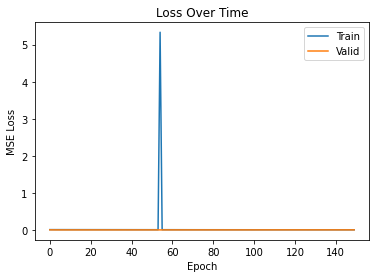

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
enc_multi_pred = scaler.inverse_transform(model.predict(X_test).reshape(X_test.shape[0], X_test.shape[1]))
enc_multi_pred = pd.Series([i[0] for i in enc_multi_pred])

In [ ]:
y_truth_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))
y_truth_test = pd.Series([i[0] for i in y_truth_test])

In [ ]:
rmse_enc_multi = sqrt(mean_squared_error(y_truth_test, enc_multi_pred))
model_score(enc_multi_pred, y_truth_test, rmse_benchmark)

RMSE: 5.285177492510479
RMSE(benchmark): 5.040526094576292
Relative RMSE (): 1.04853687756868
-4.9% improvement in RMSE as compared to Moving Average Model (Benchmark)

MAE: 4.031498448150914
Mean: 7.8323170731707314
MAE to Mean Ratio: 0.5147261545323082


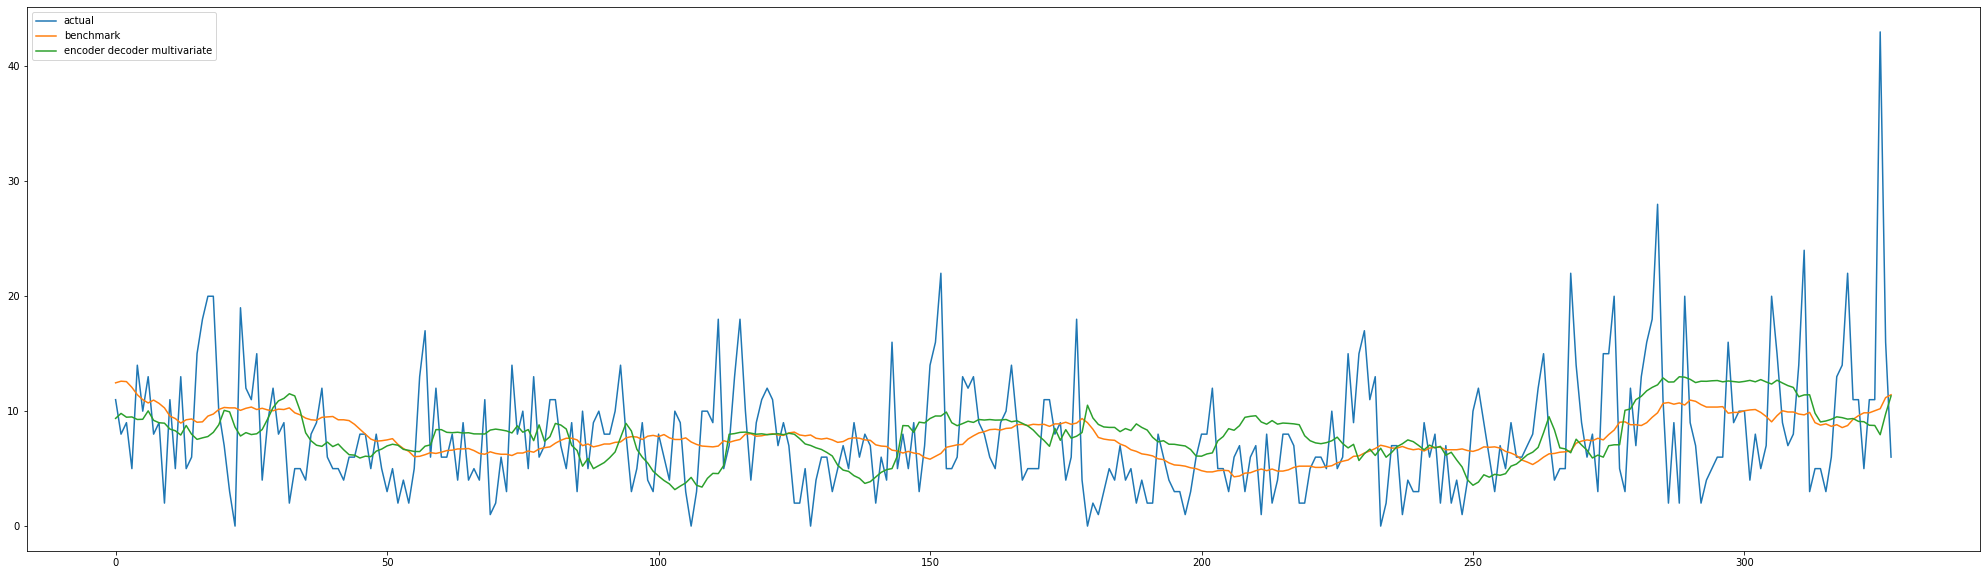

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(y_truth_test, label="actual")
plt.plot(mavg_pred, label="benchmark")
plt.plot(enc_multi_pred, label= "encoder decoder multivariate")

plt.legend()
plt.show()

# Multivariate MLP

In [ ]:
y_truth_df_scaled = y_truth_df.copy() # copy another dataframe for scaled version

# scale each column with MinMax(0,1) or only lag_diff_1 column with MinMax(-1,1)  
ct = ColumnTransformer(transformers= [('scaler1', MinMaxScaler(feature_range= (0,1)),
                                  ['Sales',	'roll_7',	'roll_14',	'roll_28', 'lag_1',	'lag_2', 'lag_3']),
                                 ('scaler2', MinMaxScaler(feature_range= (-1,1)),
                                  ['lag_diff_1'])])
y_truth_df_scaled = ct.fit_transform(y_truth_df)

# create another scaler for Sales column, to do  inverse_transform for predict sales later
scaler = MinMaxScaler(feature_range= (0,1))
scaler.fit(y_truth_df['Sales'].values.reshape(-1,1))

train, test = train_test_split(y_truth_df_scaled, test_size = 0.2)
X_train, y_train = moving_window(train, n_steps_in= 28, n_steps_out= 28)
X_test, y_test = moving_window(test, n_steps_in= 28, n_steps_out= 28)

y_train = y_train[:,:,0] # only predict sales column (i.e. first feature of dataframe)
y_test = y_test[:,:,0] # only predict sales column (i.e. first feature of dataframe)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1475, 28, 8)
(1475, 28)
(328, 28, 8)
(328, 28)


In [ ]:
n_input = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], n_input) # flatten the input to fit dense layer
# y_train = y_train[:,:,0]

X_test = X_test.reshape(X_test.shape[0], n_input) # flatten the input to fit dense layer

model = Sequential()
model.add(Dense(100, activation= 'relu', input_dim = n_input))
model.add(Dense(50, activation= 'relu'))
model.add(Dropout(rate = 0.15))
model.add(Dense(28))

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='mean_absolute_error')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100)               22500     
_________________________________________________________________
dense_12 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 28)                1428      
Total params: 28,978
Trainable params: 28,978
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_name = 'mlp_multi'
history_file = 'history_' + model_name + '.csv'
model_file = 'model_' + model_name + '.h5'

# csv_logger = CSVLogger(history_file)
# model.fit(X_train, y_train, epochs = 300, batch_size = 16, shuffle= False, validation_data=(X_test, y_test), verbose= 1, callbacks= [csv_logger])
# model.save(model_file)

# files.download(history_file)
# files.download(model_file)

In [ ]:
# Load models

model_path = 'models/' + model_file
history_path = 'models/' + history_file

model = load_model(model_path)
history = pd.read_csv(history_path)

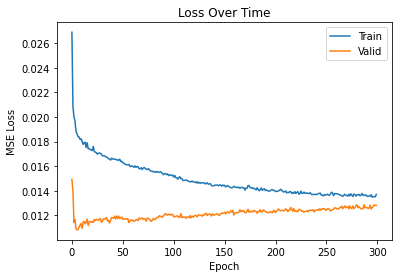

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
mlp_multi_pred = scaler.inverse_transform(model.predict(X_test))
mlp_multi_pred = pd.Series([i[0] for i in mlp_multi_pred])

In [ ]:
y_truth_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))
y_truth_test = pd.Series([i[0] for i in y_truth_test])

In [ ]:
rmse_mlp_multi = sqrt(mean_squared_error(y_truth_test, mlp_multi_pred))
model_score(mlp_multi_pred, y_truth_test, rmse_benchmark)

RMSE: 4.895030278760629
RMSE(benchmark): 5.040526094576292
Relative RMSE (): 0.971134795637261
2.9% improvement in RMSE as compared to Moving Average Model (Benchmark)

MAE: 3.715895646092732
Mean: 7.8323170731707314
MAE to Mean Ratio: 0.47443120744196815


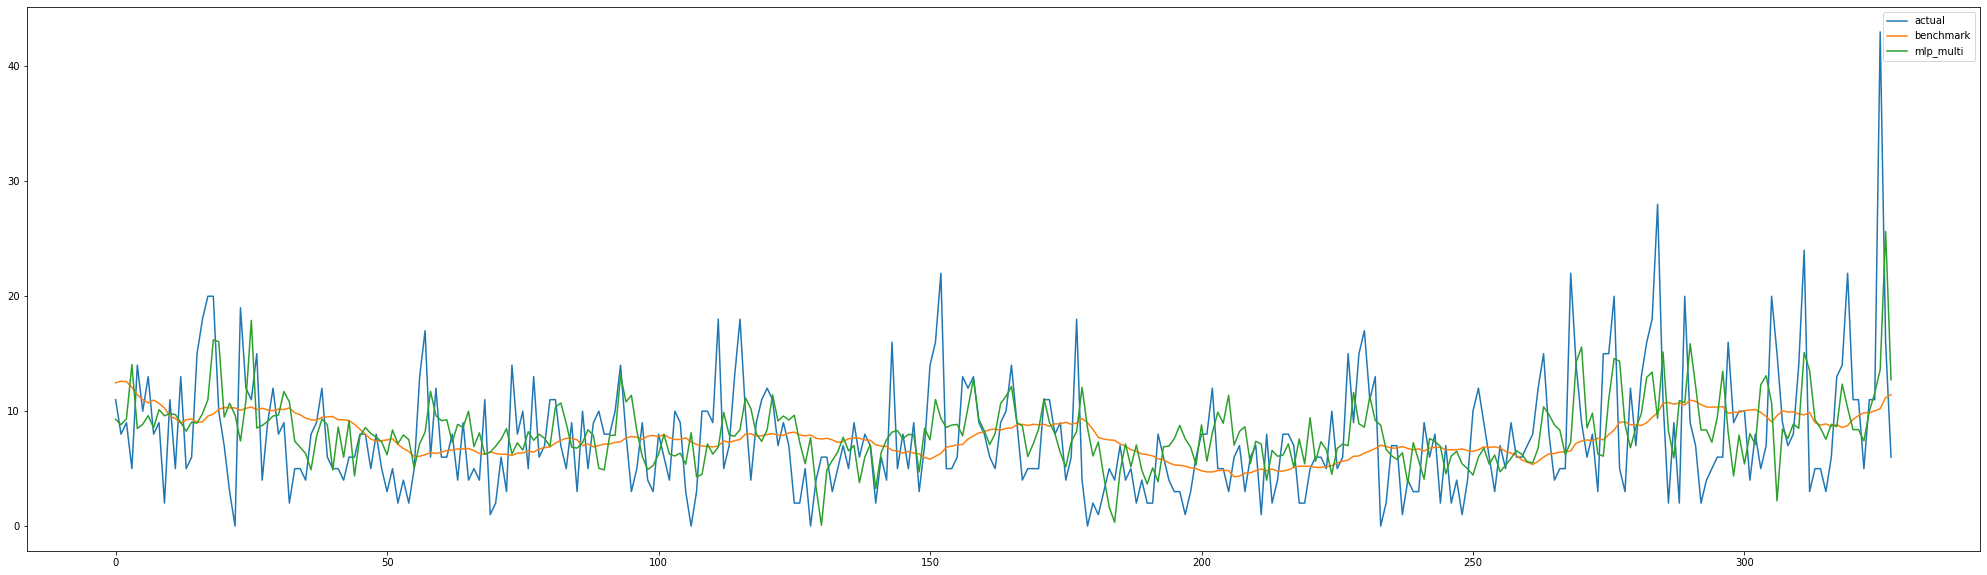

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(y_truth_test, label="actual")
plt.plot(mavg_pred, label="benchmark")
plt.plot(mlp_multi_pred, label= "mlp_multi")
plt.legend()
plt.show()

# Multivariate Vanilla Bi-Directional LSTM

In [ ]:
y_truth_df_scaled = y_truth_df.copy() # copy another dataframe for scaled version

# scale each column with MinMax(0,1) or only lag_diff_1 column with MinMax(-1,1)  
ct = ColumnTransformer(transformers= [('scaler1', MinMaxScaler(feature_range= (0,1)),
                                  ['Sales',	'roll_7',	'roll_14',	'roll_28', 'lag_1',	'lag_2', 'lag_3']),
                                 ('scaler2', MinMaxScaler(feature_range= (-1,1)),
                                  ['lag_diff_1'])])
y_truth_df_scaled = ct.fit_transform(y_truth_df)

# create another scaler for Sales column, to do  inverse_transform for predict sales later
scaler = MinMaxScaler(feature_range= (0,1))
scaler.fit(y_truth_df['Sales'].values.reshape(-1,1))

train, test = train_test_split(y_truth_df_scaled, test_size = 0.2)
X_train, y_train = moving_window(train, n_steps_in= 28, n_steps_out= 28)
X_test, y_test = moving_window(test, n_steps_in= 28, n_steps_out= 28)

y_train = y_train[:,:,0] # only predict sales column (i.e. first feature of dataframe)
y_test = y_test[:,:,0] # only predict sales column (i.e. first feature of dataframe)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1475, 28, 8)
(1475, 28)
(328, 28, 8)
(328, 28)


In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(256, activation= 'relu'), input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(Dropout(rate = 0.15))
model.add(Dense(28))

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='mean_absolute_error')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 512)               542720    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 28)                14364     
Total params: 557,084
Trainable params: 557,084
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_name = 'bilstm_multi'
history_file = 'history_' + model_name + '.csv'
model_file = 'model_' + model_name + '.h5'

# csv_logger = CSVLogger(history_file)
# model.fit(X_train, y_train, epochs = 80, batch_size = 16, shuffle= False, validation_data=(X_test, y_test), verbose= 1, callbacks= [csv_logger])
# model.save(model_file)

# files.download(history_file)
# files.download(model_file)

In [ ]:
# Load models

model_path = 'models/' + model_file
history_path = 'models/' + history_file

model = load_model(model_path)
history = pd.read_csv(history_path)

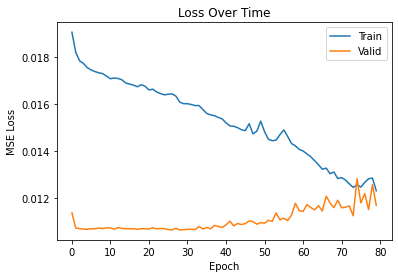

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
blstm_multi_pred = scaler.inverse_transform(model.predict(X_test))
blstm_multi_pred = pd.Series([i[0] for i in blstm_multi_pred])

In [ ]:
y_truth_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))
y_truth_test = pd.Series([i[0] for i in y_truth_test])

In [ ]:
rmse_blstm_multi = sqrt(mean_squared_error(y_truth_test, blstm_multi_pred))
model_score(blstm_multi_pred, y_truth_test, rmse_benchmark)

RMSE: 4.901189919690892
RMSE(benchmark): 5.040526094576292
Relative RMSE (): 0.9723568190559853
2.8% improvement in RMSE as compared to Moving Average Model (Benchmark)

MAE: 3.742818100605069
Mean: 7.8323170731707314
MAE to Mean Ratio: 0.47786856247507303


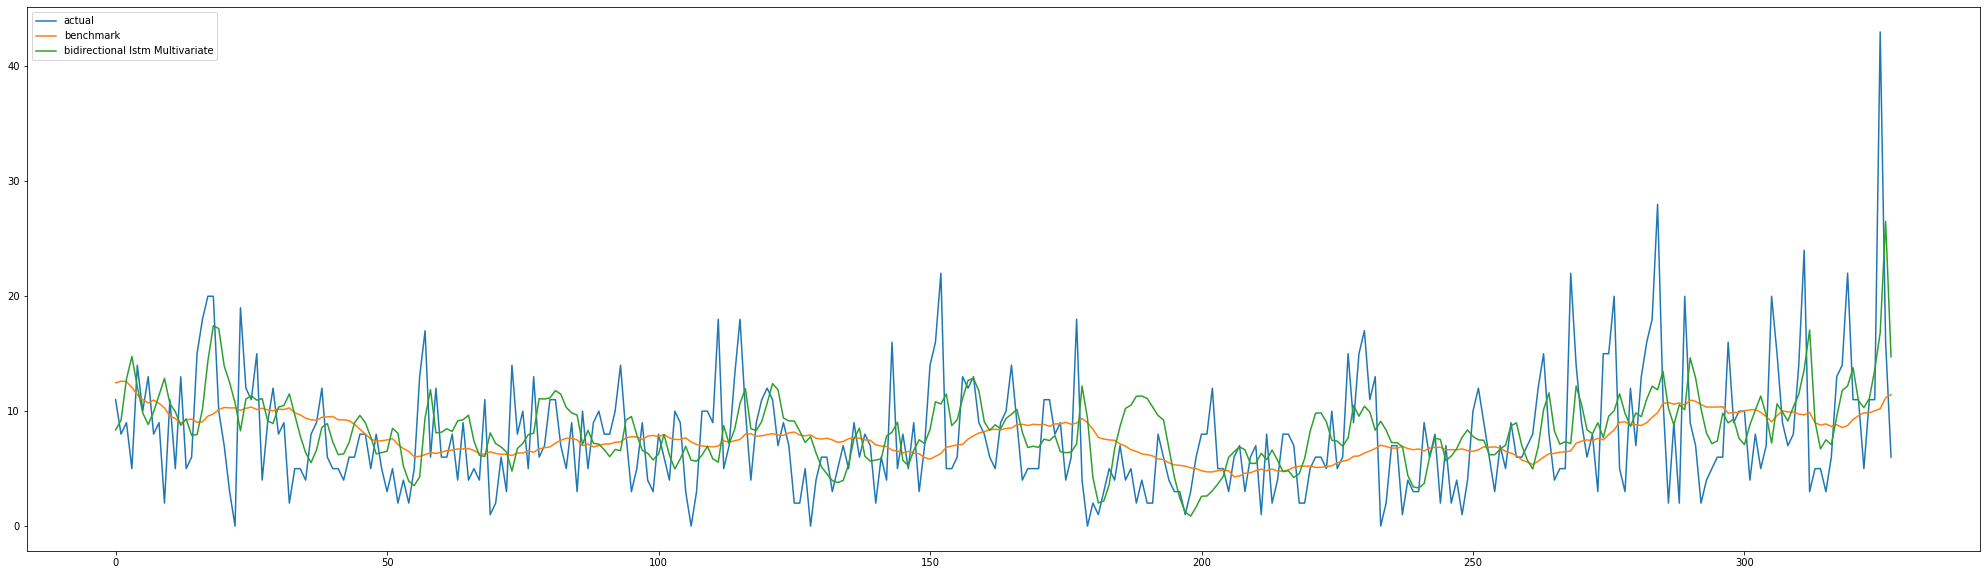

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(y_truth_test, label="actual")
plt.plot(mavg_pred, label="benchmark")
plt.plot(blstm_multi_pred, label= "bidirectional lstm Multivariate")
plt.legend()
plt.show()

# Multivariate ConvLSTM

In [ ]:
y_truth_df_scaled = y_truth_df.copy() # copy another dataframe for scaled version

# scale each column with MinMax(0,1) or only lag_diff_1 column with MinMax(-1,1)  
ct = ColumnTransformer(transformers= [('scaler1', MinMaxScaler(feature_range= (0,1)),
                                  ['Sales',	'roll_7',	'roll_14',	'roll_28', 'lag_1',	'lag_2', 'lag_3']),
                                 ('scaler2', MinMaxScaler(feature_range= (-1,1)),
                                  ['lag_diff_1'])])
y_truth_df_scaled = ct.fit_transform(y_truth_df)

# create another scaler for Sales column, to do  inverse_transform for predict sales later
scaler = MinMaxScaler(feature_range= (0,1))
scaler.fit(y_truth_df['Sales'].values.reshape(-1,1))

train, test = train_test_split(y_truth_df_scaled, test_size = 0.2)
X_train, y_train = moving_window(train, n_steps_in= 28, n_steps_out= 28)
X_test, y_test = moving_window(test, n_steps_in= 28, n_steps_out= 28)

y_train = y_train[:,:,0] # only predict sales column (i.e. first feature of dataframe)
y_test = y_test[:,:,0] # only predict sales column (i.e. first feature of dataframe)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1475, 28, 8)
(1475, 28)
(328, 28, 8)
(328, 28)


In [ ]:
# reshape train data into 4 sub-sequences of time steps [samples, subsequences, timesteps, features]

X_train = X_train.reshape(X_train.shape[0], 4, int(X_train.shape[1]/4), X_train.shape[2])
print(X_train.shape)

X_test = X_test.reshape(X_test.shape[0], 4, int(X_test.shape[1]/4), X_test.shape[2])
print(X_test.shape)

(1475, 4, 7, 8)
(328, 4, 7, 8)


In [ ]:
model = Sequential()
model.add(Input(shape = (None, X_train.shape[2], X_train.shape[3])))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))) # tried kernel_size = 3
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(rate = 0.15))
model.add(Dense(28))

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='mean_absolute_error')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, None, 7, 64)       576       
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 3, 64)       0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 192)         0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                48600     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 28)                1428      
Total params: 50,604
Trainable params: 50,604
Non-trainable params: 0
_________________________________________________

In [ ]:
model_name = 'conv_lstm_multi'
history_file = 'history_' + model_name + '.csv'
model_file = 'model_' + model_name + '.h5'

# csv_logger = CSVLogger(history_file)
# model.fit(X_train, y_train, epochs = 100, batch_size = 16, shuffle= False, validation_data=(X_test, y_test), verbose= 1, callbacks= [csv_logger])
# model.save(model_file)

# files.download(history_file)
# files.download(model_file)

In [ ]:
# Load models

model_path = 'models/' + model_file
history_path = 'models/' + history_file

model = load_model(model_path)
history = pd.read_csv(history_path)

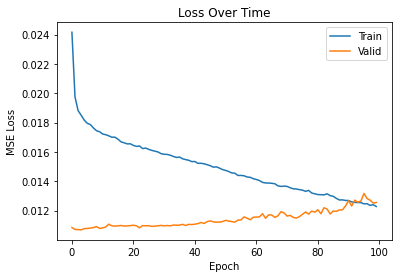

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
convlstm_multi_pred = scaler.inverse_transform(model.predict(X_test))
convlstm_multi_pred = pd.Series([i[0] for i in convlstm_multi_pred])

In [ ]:
y_truth_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))
y_truth_test = pd.Series([i[0] for i in y_truth_test])

In [ ]:
rmse_convlstm_multi = sqrt(mean_squared_error(y_truth_test, convlstm_pred))
model_score(convlstm_multi_pred, y_truth_test, rmse_benchmark)

RMSE: 5.151563990721247
RMSE(benchmark): 5.040526094576292
Relative RMSE (): 1.0220290291254386
-2.2% improvement in RMSE as compared to Moving Average Model (Benchmark)

MAE: 3.922586837192861
Mean: 7.8323170731707314
MAE to Mean Ratio: 0.5008207405991664


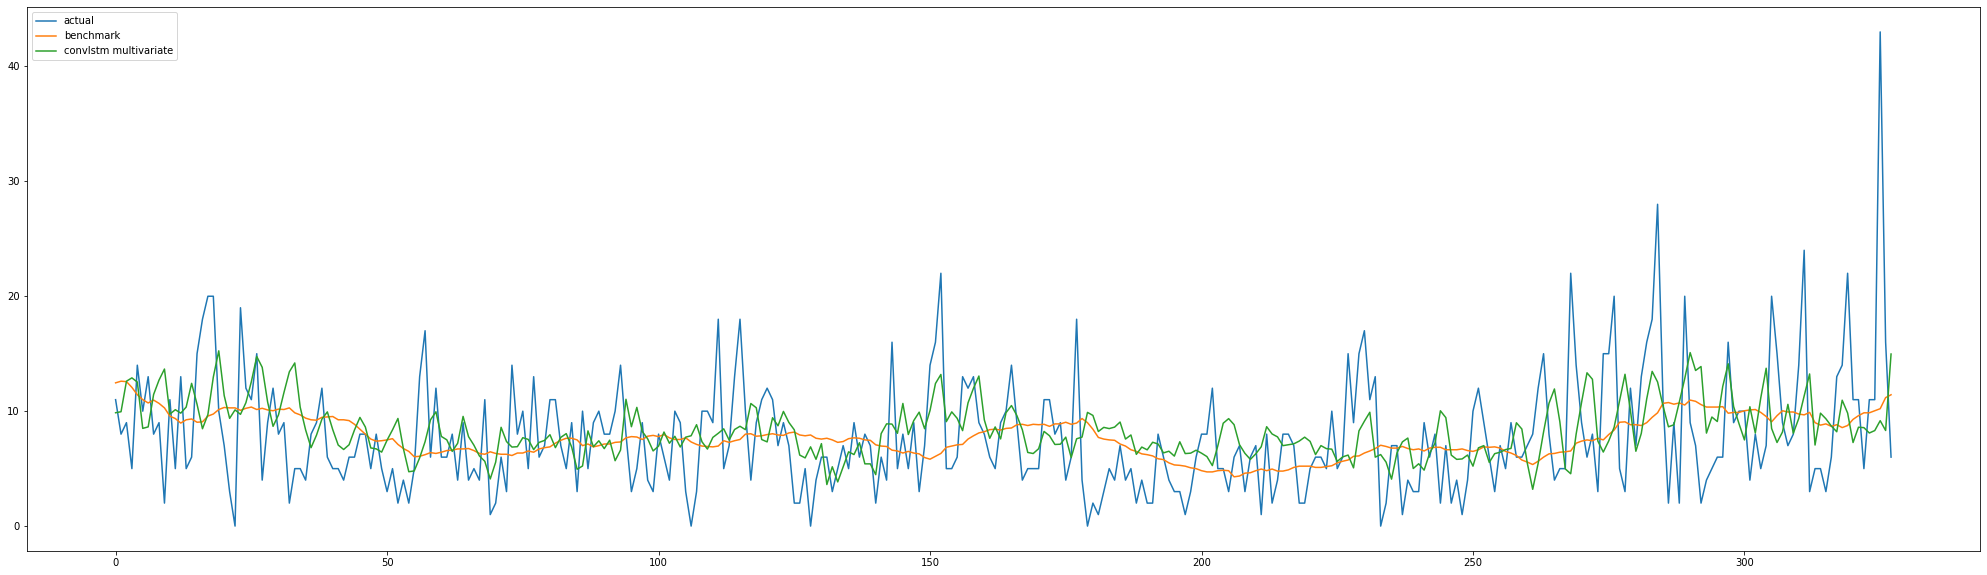

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(y_truth_test, label="actual")
plt.plot(mavg_pred, label="benchmark")
# plt.plot(lstm_pred, label= "lstm")
plt.plot(convlstm_multi_pred, label= "convlstm multivariate")
plt.legend()
plt.show()

# Multivariate Wavenet

In [ ]:
y_truth_df_scaled = y_truth_df.copy() # copy another dataframe for scaled version

# scale each column with MinMax(0,1) or only lag_diff_1 column with MinMax(-1,1)  
ct = ColumnTransformer(transformers= [('scaler1', MinMaxScaler(feature_range= (0,1)),
                                  ['Sales',	'roll_7',	'roll_14',	'roll_28', 'lag_1',	'lag_2', 'lag_3']),
                                 ('scaler2', MinMaxScaler(feature_range= (-1,1)),
                                  ['lag_diff_1'])])
y_truth_df_scaled = ct.fit_transform(y_truth_df)

# create another scaler for Sales column, to do  inverse_transform for predict sales later
scaler = MinMaxScaler(feature_range= (0,1))
scaler.fit(y_truth_df['Sales'].values.reshape(-1,1))

train, test = train_test_split(y_truth_df_scaled, test_size = 0.2)
X_train, y_train = moving_window(train, n_steps_in= 28, n_steps_out= 28)
X_test, y_test = moving_window(test, n_steps_in= 28, n_steps_out= 28)

y_train = y_train[:,:,0] # only predict sales column (i.e. first feature of dataframe)
y_test = y_test[:,:,0] # only predict sales column (i.e. first feature of dataframe)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1475, 28, 8)
(1475, 28)
(328, 28, 8)
(328, 28)


In [ ]:
# Ref:https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Full.ipynb
# Ref2:https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv2/

# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
  # preprocessing - equivalent to time-distributed dense
  x = Conv1D(16, 1, padding='same', activation='relu')(x) 
  
  # filter convolution
  x_f = Conv1D(filters=n_filters,
                kernel_size=filter_width, 
                padding='causal',
                dilation_rate=dilation_rate)(x)
  
  # gating convolution
  x_g = Conv1D(filters=n_filters,
                kernel_size=filter_width, 
                padding='causal',
                dilation_rate=dilation_rate)(x)
  
  # multiply filter and gating branches
  z = Multiply()([Activation('tanh')(x_f),
                  Activation('sigmoid')(x_g)])
  
  # postprocessing - equivalent to time-distributed dense
  z = Conv1D(16, 1, padding='same', activation='relu')(z)
  
  # residual connection
  x = Add()([x, z])    
  
  # collect skip connections
  skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

model = Model(history_seq, out)
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics='mean_absolute_error')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 8)]      0                                            
__________________________________________________________________________________________________
conv1d_68 (Conv1D)              (None, 28, 16)       144         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_69 (Conv1D)              (None, 28, 32)       1056        conv1d_68[0][0]                  
__________________________________________________________________________________________________
conv1d_70 (Conv1D)              (None, 28, 32)       1056        conv1d_68[0][0]                  
____________________________________________________________________________________________

In [ ]:
model_name = 'wavenet_multi'
history_file = 'history_' + model_name + '.csv'
model_file = 'model_' + model_name + '.h5'

# csv_logger = CSVLogger(history_file)
# model.fit(X_train, y_train, epochs = 100, batch_size = 16, shuffle= False, validation_data=(X_test, y_test), verbose= 1, callbacks= [csv_logger])
# model.save(model_file)

# files.download(history_file)
# files.download(model_file)

In [ ]:
# Load models

model_path = 'models/' + model_file
history_path = 'models/' + history_file

model = load_model(model_path)
history = pd.read_csv(history_path)

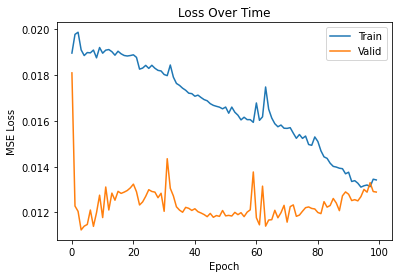

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
wavenet_multi_pred = model.predict(X_test)[:,:,0]
wavenet_multi_pred = scaler.inverse_transform(wavenet_multi_pred)
wavenet_multi_pred = pd.Series([i[0] for i in wavenet_multi_pred])

In [ ]:
y_truth_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))
y_truth_test = pd.Series([i[0] for i in y_truth_test])

In [ ]:
rmse_wavenet_multi = sqrt(mean_squared_error(y_truth_test, wavenet_multi_pred))
model_score(wavenet_multi_pred, y_truth_test, rmse_benchmark)

RMSE: 5.385265681899312
RMSE(benchmark): 5.040526094576292
Relative RMSE (): 1.0683935725863944
-6.8% improvement in RMSE as compared to Moving Average Model (Benchmark)

MAE: 4.2264435305828005
Mean: 7.8323170731707314
MAE to Mean Ratio: 0.5396159898914592


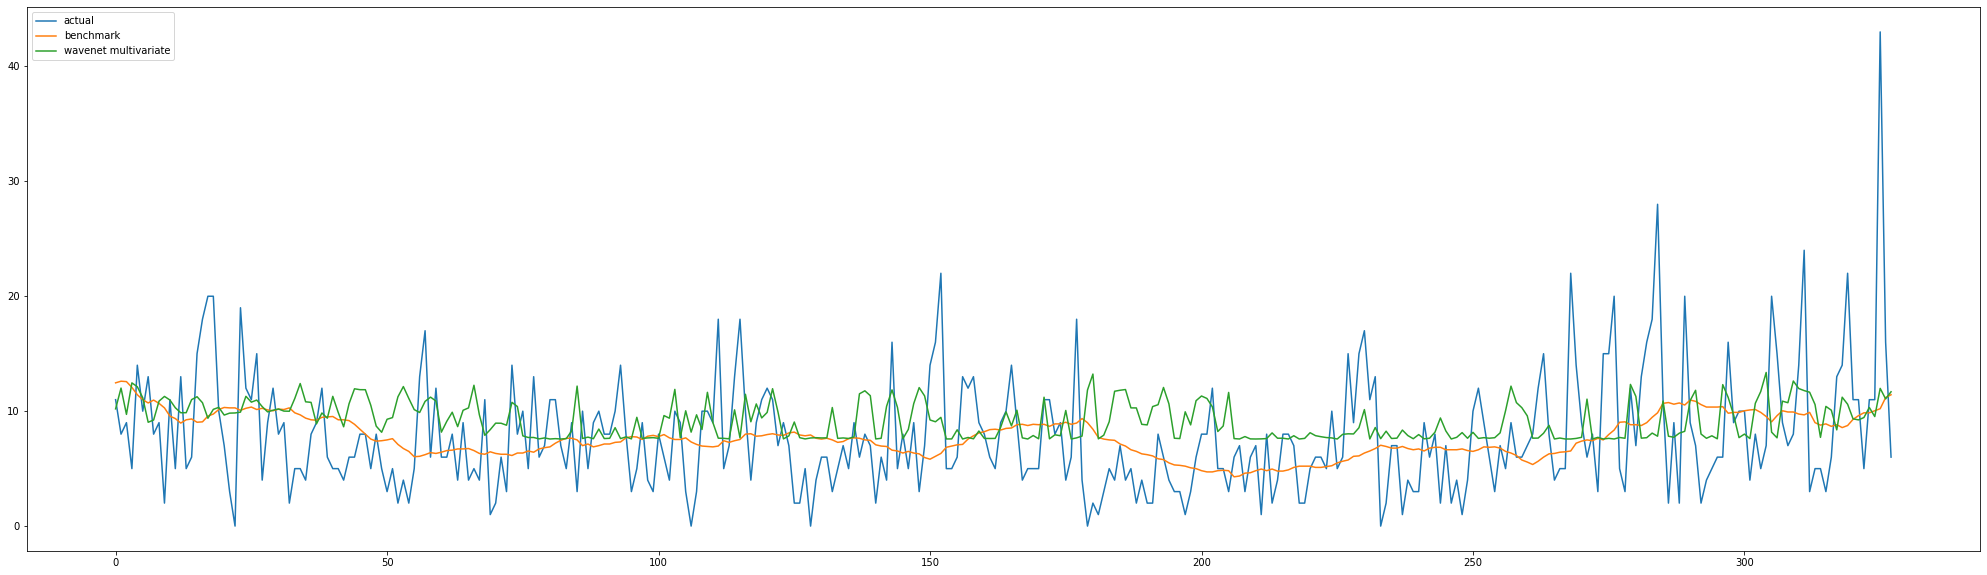

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(y_truth_test, label="actual")
plt.plot(mavg_pred, label="benchmark")
plt.plot(wavenet_multi_pred, label= "wavenet multivariate")
plt.legend()
plt.show()

# Conclusion: Models Comaprison

In [ ]:
rmse_compairson = pd.DataFrame([rmse_benchmark, rmse_lstm, rmse_lstm_multi, rmse_slstm, rmse_slstm_multi, rmse_enc, rmse_enc_multi, rmse_mlp, rmse_mlp_multi, rmse_blstm, rmse_blstm_multi, 
 rmse_convlstm, rmse_convlstm_multi, rmse_wavenet, rmse_wavenet_multi]).T
rmse_compairson.columns = ['MOVING AVERAGE (benchmark)', 'LSTM UNI', 'LSTM MULTI', 'STACKED LSTM UNI', 'STACKED LSTM MULTI', 'ENC-DEC LSTM UNI', 'ENC-DEC LSTM MULTI', 'MLP UNI', 'MLP MULTI',
                           'BI-DIREC LSTM UNI', 'BI-DIREC LSTM MULTI','CONV LSTM UNI','CONV LSTM MULTI', 'WAVENET UNI', 'WAVENET MULTI']
rmse_compairson

MOVING AVERAGE (benchmark)  LSTM UNI  ...  WAVENET UNI  WAVENET MULTI
0                    5.040526   4.92649  ...     5.367339       5.385266

[1 rows x 15 columns]

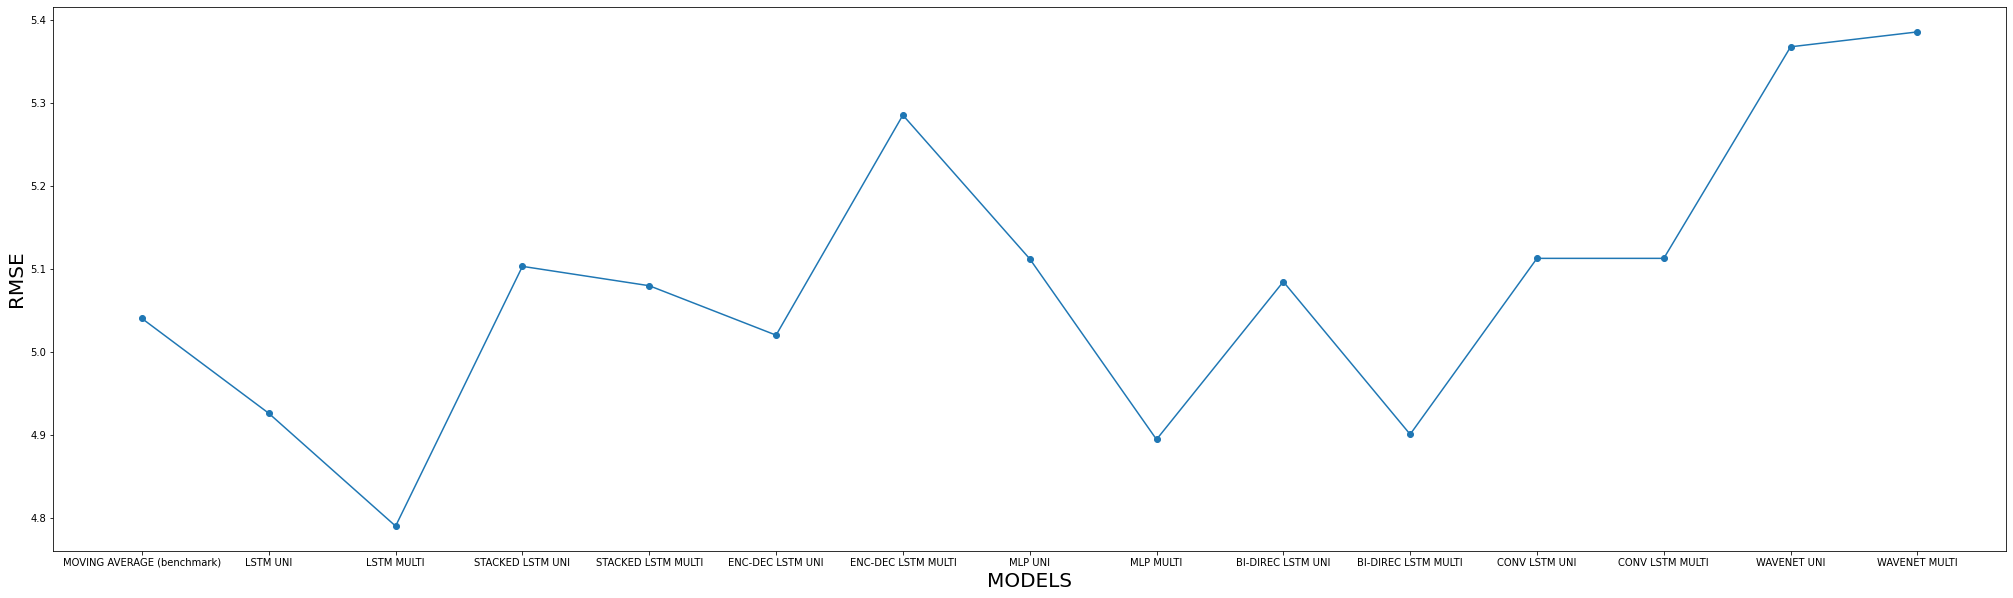

In [ ]:
plt.figure(figsize=(35,10))
plt.plot(rmse_compairson.T, marker = 'o', )
plt.xlabel('MODELS', fontsize = 20)
plt.ylabel('RMSE', fontsize = 20)
plt.show()

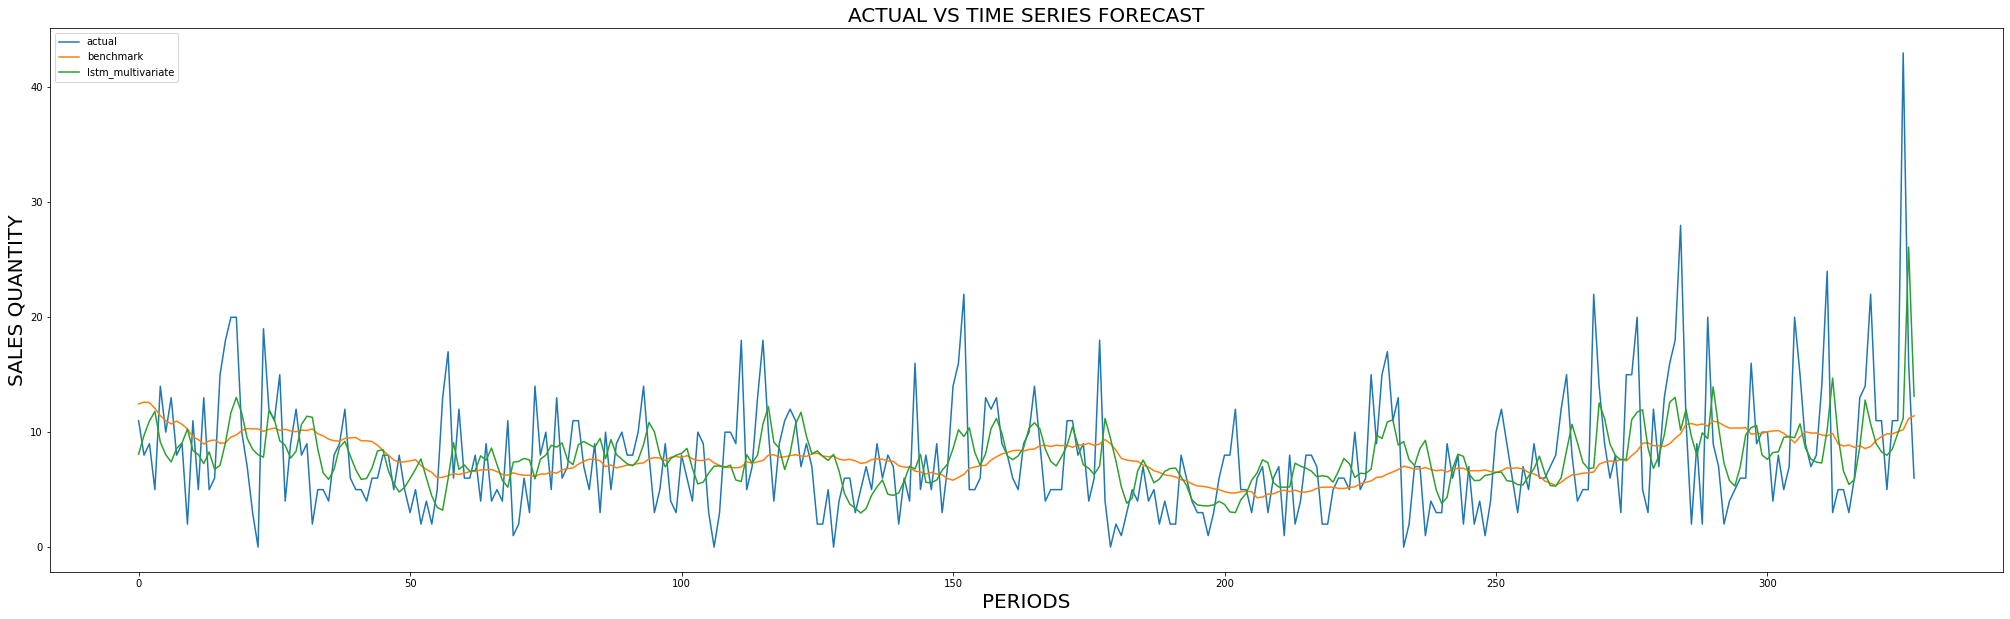

In [ ]:
# Best Model

plt.figure(figsize=(35,10))
plt.plot(y_truth_test, label="actual")
plt.plot(mavg_pred, label="benchmark")
plt.plot(lstm_multi_pred, label= "lstm_multivariate")
plt.xlabel('PERIODS', fontsize = 20)
plt.ylabel('SALES QUANTITY', fontsize = 20)
plt.legend()
plt.title('ACTUAL VS TIME SERIES FORECAST', fontsize = 20)
plt.show()

Observation 1: Multivariate version tends to do better than univariate other than 2 models (Encoder-Decoder and Wavenet)

Observation 2: LSTM Multivariant has the lowest RMSE, followed by MLP and Bi-Directional LSTM. The LSTM Multivariate has about 5% improvement in RMSE as compared to the benchmark model (moving average)

Future Work: As the observations above are only based on forecasting 1 material sample, there is a need to forecast for the remaining materials to backup the observations with larger sample size